 #### Silvestro di Luise [silvestro.diluise@gmail.com]

 - This notebook contains some non static elements (indexes, maps), it is 
    suggested to visualize via the Jupyter nbviewer for proper rendering:
    paste github link of this notebook here: [nbviewer.jupyter.org](http://nbviewer.jupyter.org/)

<a id='Introduction'></a>
***
***
***
# Introduction
***
***
***
- First part of the data processing/preparation is performed on a Spark Data Frame. This is in principle not
necessary on a small dataset like the one under study. 
Neverthless the Spark framework has been used since that would be the way to proceed in the case of a very large dataset distributed on (HDFS) cluster.  
The tool used is PySpark.

- The second part of data processing/preparation: characterization and modelling
  is performed on a Pandas Data Frame.
  After data cleaning it is advisable to perform data exploration and modelling on a small part of the data
  stored to on locally resident object. 
  Tools used: Pandas, numpym scikit learn, ...
  The full pipeline can then be run on the distributed dataset using Spark MLLib package to implent
  the ML algorithm.
  
  

<a id='Index'></a>
#### Quickjump Index
   [General Settings](#General_Settings)  
   [Data Ingestion](#Data_Ingestion)  
   [Data Preparation: Inspection, Cleaning, Fixing, Validation](#Data_Preparation)  
   [Data Analytics](#Data_Analytics)  
   [Conclusions](#Conclusions)

<a id='General_Settings'></a>
***
# General Settings
***

In [1]:
# write all outputs not only last one in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
# enable retina display quality for figures
%config InlineBackend.figure_format = 'retina'

In [3]:
# do not show warnings (turn on for final presentation)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# platform setting
import os, sys, platform
platform.python_version()

'2.7.12'

In [5]:
# some utility 
import numpy as np

In [6]:
# Pandas module import and cofiguration

import pandas as pd

# avoid truncation when displaying long field values
pd.set_option('display.max_colwidth', -1)

# avoid column truncation when displaying high dimension data frames 
pd.set_option('display.max_columns', None)

#
pd.options.display.max_rows = 999

# avoid long decimal printouts
pd.options.display.float_format = '{:,.5f}'.format

## Spark environment setup

In [7]:
from pyspark import SparkContext, SQLContext, SparkConf

conf = SparkConf().setMaster("local").set("spark.driver.memory", "1g").set("spark.executor.memory", "1g") 
        
sc = SparkContext(conf = conf)

 - Start a Spark session

In [8]:
#spark object entry point Spark 2.0, handle to a spark session
from pyspark.sql import SparkSession
spark = SparkSession(sc)
spark.version

u'2.2.0'

 - Set number of partitions. That is not necessary on small dataset and while running Spark locally  
   But it is in general advisable to optimize this setting

In [9]:
spark.conf.get("spark.sql.shuffle.partitions")
spark.conf.set("spark.sql.shuffle.partitions",2)
spark.conf.get("spark.sql.shuffle.partitions")

u'200'

u'2'

Load utiity functions and data types

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, DoubleType, TimestampType

<a id='Data_Ingestion'></a>
***
***
***
# Data Ingestion
***
***
***
[to index](#Index)

 - Data is a set of partitions saved in parquet format
 - Since the data set if a few MBs, distributed over about 40 partitions,
   it is possible to list single files to test file state individually

In [11]:
# set path to input data
data_path = 'Data/zubie_trips_anonymous/'

In [12]:
# list local data directory 
!ls -ltrh Data/zubie_trips_anonymous | grep .parquet | awk '{print $5, $9}' 

5.8K part-00037-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00036-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00035-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00034-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00033-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00032-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00031-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00030-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00029-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00028-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00027-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00026-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00025-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00024-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet
5.8K part-00023-3927ef29-1d8d-4f92-bb39-ac1f52d7

In [13]:
# loop over files using HDFS filesystem interface as if data would be on cluster
# read data files and print row counts 

hadoop = spark._jvm.org.apache.hadoop
fs   = hadoop.fs.FileSystem
conf = hadoop.conf.Configuration() 
path = hadoop.fs.Path(data_path)

for f in fs.get(conf).listStatus(path):
    name =  str(f.getPath())
    if name.endswith('.parquet'):
        counts = spark.read.parquet(name).count()  
        print ("{}, rows: {} ".format( name.split('/')[-1], counts) )

part-00000-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 8530 
part-00001-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 4922 
part-00002-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 3115 
part-00003-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 2202 
part-00004-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 1701 
part-00005-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 2508 
part-00006-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 1803 
part-00007-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 1357 
part-00008-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 1102 
part-00009-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 856 
part-00010-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 534 
part-00011-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 281 
part-00012-3927ef29-1d8d-4f92-bb39-ac1f52d70583.snappy.parquet, rows: 41 
part-00013-3927ef

 - Load whole data set into a Spark DataFrame  
   Get total number of rows

In [14]:
df = spark.read.parquet(data_path)

numOfFieldsRaw = len(df.columns)

numOfRows = df.count()
numOfRowsRaw = numOfRows

print ( "total num of fields: {}".format( numOfFieldsRaw ) )
print ( "total num of rows: {}".format( numOfRowsRaw ) )


total num of fields: 56
total num of rows: 28952


 - Number of Partitions

In [15]:
print ( "Number of partitions: {}".format(df.rdd.getNumPartitions()) )

Number of partitions: 2


- Print Data Frame Schema: field Name and Type

In [16]:
print ( " Data Frame Schema: " )
df.printSchema()

 Data Frame Schema: 
root
 |-- device_key: string (nullable = true)
 |-- distance_um: string (nullable = true)
 |-- duration_seconds: double (nullable = true)
 |-- end_point_address_city: string (nullable = true)
 |-- end_point_address_country: string (nullable = true)
 |-- end_point_address_state: string (nullable = true)
 |-- end_point_address_zipcode: string (nullable = true)
 |-- end_point_daylight_saving_time_flag: boolean (nullable = true)
 |-- end_point_latitude: double (nullable = true)
 |-- end_point_longitude: double (nullable = true)
 |-- end_point_place: string (nullable = true)
 |-- end_point_timestamp: string (nullable = true)
 |-- end_point_timestamp_tz: string (nullable = true)
 |-- end_point_timestamp_utc: string (nullable = true)
 |-- fuel_consumed: string (nullable = true)
 |-- fuel_consumed_um: string (nullable = true)
 |-- fuel_cost: string (nullable = true)
 |-- fuel_cost_currency_code: string (nullable = true)
 |-- fuel_cost_currency_symbol: string (nullable = tr

<a id='Data_Preparation'></a>
***
***
***
# Data Preparation: Inspection, Cleaning, Fixing, Validation
***
***
***
[to index](#Index)

- Analysis performed on Spark Data Frame

### First lookat the Data 
-  To visualize table data, a few rows of Spark DF are retrieved and tranformed to a Pandas DF for better formatting 

In [18]:
df.limit(10).toPandas()

device_key  \
0  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
1  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
3  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
4  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
5  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
6  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
7  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
8  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
9  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   

  distance_um  duration_seconds end_point_address_city  \
0  mi         425.00000          Cleckheaton             
1  mi         235.00000          Cleckheaton             
2  mi         2,439.00000        Cleckheaton             
3  mi         738.00000          Luddenden Foot          
4  mi         1,808.00000        Halifax                 
5  mi         241.00000          Cleckheaton             
6  mi         252.00000          Cleckheaton             
7  mi         2,366.00000        Cleckheaton             
8  mi         526.00000          Luddenden Foot          
9  mi         532.00000          Halifax                 

  end_point_address_country end_point_address_state end_point_address_zipcode  \
0  GB                        England                 BD19 3TY                   
1  GB                        England                 BD19 3BJ                   
2  GB                        England                 BD19 3TY                   
3  GB                        England                 HX2                        
4  GB                        England                 HX1 3BA                    
5  GB                        England                 BD19 3TY                   
6  GB                        England                 BD19 3HU                   
7  GB                        England                 BD19 3TY                   
8  GB                        England                 HX2 6AH                    
9  GB                        England                 HX1 3BA                    

  end_point_daylight_saving_time_flag  end_point_latitude  \
0  False                              53.73208              
1  False                              53.72505              
2  False                              53.73204              
3  False                              53.72361              
4  False                              53.71443              
5  False                              53.73208              
6  False                              53.72507              
7  False                              53.73207              
8  False                              53.72363              
9  False                              53.71457              

   end_point_longitude end_point_place  end_point_timestamp  \
0 -1.71761              None            2016-11-24 12:33:01   
1 -1.71570              None            2016-11-24 12:12:05   
2 -1.71758              None            2016-11-24 08:28:24   
3 -1.94621              None            2016-11-23 17:55:30   
4 -1.87809              None            2016-11-23 17:32:16   
5 -1.71757              None            2016-11-23 13:50:00   
6 -1.71529              None            2016-11-23 13:35:05   
7 -1.71757              None            2016-11-23 08:27:53   
8 -1.94622              None            2016-11-22 21:39:30   
9 -1.87801              None            2016-11-22 21:25:20   

  end_point_timestamp_tz end_point_timestamp_utc fuel_consumed  \
0  GMT                    2016-11-24 12:33:01     None           
1  GMT                    2016-11-24 12:12:05     None           
2  GMT                    2016-11-24 08:28:24     None           
3  GMT                    2016-11-23 17:55:30     None           
4  GMT                    2016-11-23 17:32:16   


### Remove  all-NA Fields
   - From the display looks like several fields have all 'None' values
   - Non-NA occurences are computed individually for selected field and confirmed that 0 rows are left out
   - Columns are removed 
   - It is important to remove those fields otherwise all the rows will be removed  
     when in the following you want to drop rows with at least one NA field.
     

In [19]:
# Selected columns to inspect and eventually to drop
cols = ['user','start_point_place','end_point_place','mpg_combined','fuel_consumed','fuel_cost']

# count number of NA 
for col in cols:
  print ( "field: \'{}\', Number of non NULL entries: {} "
         .format( col, df.select(col).dropna().count() ) 
        )

# 'tags' field contains an array, let's expand it before counting for missing values
print ( "field: \'tags\',  Number of non NULL entries: {}"
       .format( df.select(F.explode('tags')).dropna().count() ) 
      )

# append to the list of columns 
cols.append('tags')

# apply drop function iteratively on selected columns
from functools import reduce
from pyspark.sql import DataFrame

df = reduce(DataFrame.drop, cols, df)

print ("\n Columns have been dropped ")


field: 'user', Number of non NULL entries: 0 
field: 'start_point_place', Number of non NULL entries: 0 
field: 'end_point_place', Number of non NULL entries: 0 
field: 'mpg_combined', Number of non NULL entries: 0 
field: 'fuel_consumed', Number of non NULL entries: 0 
field: 'fuel_cost', Number of non NULL entries: 0 
field: 'tags',  Number of non NULL entries: 0

 Columns have been dropped 


### Remove Duplicated Rows
   - More than 80% of the rows in the dataset are duplicates
   - This reduce the effective DF entries from ~30k to ~5k 
   - A quick check is done to show that this is indeed the case

In [20]:
# transfom Spark DF into Pandas DF. 
# (for large distributed dataset it would be necessary to sample only a franction
# of it before)
# Keep only duplicated rows
# Select a single vehicle_nickname, order by date
# Show table
pdf = df.toPandas()

pdf[ pdf.duplicated() ]\
   [ pdf['vehicle_nickname']==pdf['vehicle_nickname'].values[0] ]\
   .set_index('start_point_timestamp')\
   .sort_index()\
   .head(10)


device_key  \
start_point_timestamp                                                                     
2016-09-15 17:42:06    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 17:42:06    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 17:42:06    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 17:42:06    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 18:53:20    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 18:53:20    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 18:53:20    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-15 18:53:20    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-16 10:53:46    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2016-09-16 10:53:46    agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   

                      distance_um  duration_seconds end_point_address_city  \
start_point_timestamp                                                        
2016-09-15 17:42:06    mi         774.00000          Halifax                 
2016-09-15 17:42:06    mi         774.00000          Halifax                 
2016-09-15 17:42:06    mi         774.00000          Halifax                 
2016-09-15 17:42:06    mi         774.00000          Halifax                 
2016-09-15 18:53:20    mi         919.00000          Luddenden Foot          
2016-09-15 18:53:20    mi         919.00000          Luddenden Foot          
2016-09-15 18:53:20    mi         919.00000          Luddenden Foot          
2016-09-15 18:53:20    mi         919.00000          Luddenden Foot          
2016-09-16 10:53:46    mi         144.00000          Luddenden Foot          
2016-09-16 10:53:46    mi         144.00000          Luddenden Foot          

                      end_point_address_country end_point_address_state  \
start_point_timestamp                                                     
2016-09-15 17:42:06    GB                        England                  
2016-09-15 17:42:06    GB                        England                  
2016-09-15 17:42:06    GB                        England                  
2016-09-15 17:42:06    GB                        England                  
2016-09-15 18:53:20    GB                        England                  
2016-09-15 18:53:20    GB                        England                  
2016-09-15 18:53:20    GB                        England                  
2016-09-15 18:53:20    GB                        England                  
2016-09-16 10:53:46    GB                        England                  
2016-09-16 10:53:46    GB                        England                  

                      end_point_address_zipcode  \
start_point_timestamp                             
2016-09-15 17:42:06    HX1                        
2016-09-15 17:42:06    HX1                        
2016-09-15 17:42:06    HX1                        
2016-09-15 17:42:06    HX1                        
2016-09-15 18:53:20    HX2                        
2016-09-15 18:53:20    HX2                        
2016-09-15 18:53:20    HX2                        
2016-09-15 18:53:20    HX2                        
2016-09-16 10:53:46    HX2 6NS                    
2016-09-16 10:53:46    HX2 6NS                    

                      end_point_daylight_saving_time_flag  end_point_latitude  \
start_point_timestamp                                                           
2016-09-15 17:42:06    True                               53.72095              
2016-09-15 17:42:06    True                               53.72095              
2016-09-15 17:42:06    True                               53.72095              
2016-09-15 17:42:06    True                               53.72095              
2016-09-15 18:53:20    True                    

 - Get a new DF with unique rows

In [21]:
df = df.dropDuplicates()

print( "Number of unique rows/total  {}/{}".format( df.count(), numOfRows ) )

numOfRows = df.count()

Number of unique rows/total  5295/28952


### Drop rows with NA fields
- Dropping all the rows with at lest one NA field preserve about 75% of the data
- This is an acceptable loss for now, individual fields can be made to discard from the
  selection fields we are not interested in.  
  To prepare for this counts are coumputed for each field beforehand

In [22]:
# get single field NA counts
for c in df.columns:
  n = df.where( F.col(c).isNull() ).count()
  print ("\'{}\' -- null counts/total: {}/{}".format(c, n, numOfRows))



'device_key' -- null counts/total: 0/5295
'distance_um' -- null counts/total: 0/5295
'duration_seconds' -- null counts/total: 57/5295
'end_point_address_city' -- null counts/total: 483/5295
'end_point_address_country' -- null counts/total: 108/5295
'end_point_address_state' -- null counts/total: 145/5295
'end_point_address_zipcode' -- null counts/total: 131/5295
'end_point_daylight_saving_time_flag' -- null counts/total: 57/5295
'end_point_latitude' -- null counts/total: 57/5295
'end_point_longitude' -- null counts/total: 57/5295
'end_point_timestamp' -- null counts/total: 57/5295
'end_point_timestamp_tz' -- null counts/total: 153/5295
'end_point_timestamp_utc' -- null counts/total: 57/5295
'fuel_consumed_um' -- null counts/total: 0/5295
'fuel_cost_currency_code' -- null counts/total: 0/5295
'fuel_cost_currency_symbol' -- null counts/total: 0/5295
'fuel_ppg' -- null counts/total: 57/5295
'fuel_type' -- null counts/total: 57/5295
'gps_distance' -- null counts/total: 511/5295
'gps_miles'

In [23]:
# drop all rows with one or more NA field 
df = df.dropna(how='any')

print( "Number of non-NA rows/total:  {}/{}".format( df.count(), numOfRows ) )

numOfRows = df.count()

Number of non-NA rows/total:  3903/5295


### check URL field 
   - This varible may contain useful information however direct inspection of a few links 
      reveals that they are not available
   - Second check: a random 10% sample is extracted to perfom a URL request. 
   - An error code (4xx) is returned. 
   - The associate column is dropped

In [24]:
# extract a few rows to show URL
df.select('static_map_url').limit(5).toPandas() #show(5,truncate=False)

import requests

# sample 10% of the rows and get status code request (retain on 5 for printing)
for url in [ c['static_map_url'] for c in df.sample(False,0.1,seed=0).limit(5).rdd.collect() ]:
  print (url)
  code = requests.get(url).status_code 
  print (' satus code {}\n'.format( code ))

# drop column
df = df.drop('static_map_url')

static_map_url
0  https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWUmVUaEpUNlFaRmJhQ1IyREtTTmFSNww/staticmap?t=QTd3VNpBsUxZ7dW2GPUkOycYN48
1  https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWOEViRzVwb0FDc21vSzdabkpQTTZraAw/staticmap?t=MWYD3chkvl1AqUxUwsrviEnxn0U
2  https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWRE14bjNIYUtIUlVrRXlTVHRjeW9mZww/staticmap?t=y0KEAxjFAOE5zvZr7dlueq_gCFo
3  https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWdGNtVmh4ejhSbmg5NGNScXY3WXR4eQw/staticmap?t=Dk0uV27dMBIVyQDR05r_bayFUFg
4  https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWaVM3QkFEV1FYNGJINDI4d05lV1ptaQw/staticmap?t=4GOnC6A4FNpOm4pd_UHYX3FMQDU

https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFmhHUXpCR1pNNGlMTmd1c1hSaDQ3OVYMCxIEVHJpcCIWUGdrU1c0VTk4elhIa3loNm9nYnJNQQw/staticmap?t=zbcV_wL30OM09PX2kaVtAX-YgJE
 satus code 401

https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFmhHUXpCR1pNNGlMTmd1c1hSaDQ3OVYMCxIEVHJpcCIWeXZaa2k4YlR3WFN1SFhWaEx6NlV0Sgw/staticmap?t=Ecj7eDIdrNi6-JxCivDWz1YpYE8
 satus code 401

https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFmhHUXpCR1pNNGlMTmd1c1hSaDQ3OVYMCxIEVHJpcCIWVFpUb05GQnNOMjJoNVRGa0FBZW82cAw/staticmap?t=ULs57abB8w_vpHmAOx1-UpHz6Zw
 satus code 401

https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFlRROHlDUzlQNzhNNGlENVhwMmgzU0IMCxIEVHJpcCIWUGVyV0tzUXZ6bjNzNDhGV0czYzZCTAw/staticmap?t=eMr5-d6LrEnh8un0eagf7Xz5mGY
 satus code 401

https://zubie-eu.appspot.com/api/v1/trips/agplfnp1YmllLWV1ckILEgZEZXZpY2UiFlRROHlDUzlQNzhNNGlENVhwMmgzU0IMCxIEVHJpcCIWZTJIdm90aEgyVld2eVhuUHV0cWVxRQw/staticmap?t=S-Xbx0NfpK

### Check Unit of Measurement
   - Control if the same unit of measurment is used for all the entries of the same field  
      If different units are used, values would be convert to a common one  
      In the present sample the same units are used for distance, speed and fuel consumption
   - Currency can be EUR or USD and the fuel price per gallon is constant  
      We know already that fuel_consumed field is empty so those information can be dropped

In [25]:
# list how many distinct units exists for distance,speed and fuel_consumed
df.select('distance_um').distinct().show()

df.select('speed_um').distinct().show()

df.select('fuel_consumed_um').distinct().show()

# list how many different combination exists for currency, symbol and price per gallon of fuel.
df.select('fuel_cost_currency_code','fuel_cost_currency_symbol','fuel_ppg').distinct().show()

# drop fuel ralted fields since there no observations are available (e.g.: fuel_consumed is empty)
df = df.drop('fuel_cost_currency_code','fuel_cost_currency_symbol','fuel_ppg','fuel_consumed_um')


+-----------+
|distance_um|
+-----------+
|         mi|
+-----------+

+--------+
|speed_um|
+--------+
|     mph|
+--------+

+----------------+
|fuel_consumed_um|
+----------------+
|             gal|
+----------------+

+-----------------------+-------------------------+--------+
|fuel_cost_currency_code|fuel_cost_currency_symbol|fuel_ppg|
+-----------------------+-------------------------+--------+
|                    EUR|                        €|    2.39|
|                    USD|                        $|    3.54|
+-----------------------+-------------------------+--------+



### Redundant Fields
   - From data display looks like some field columns are duplicated 
   - To control the all the values are the same in principle it is possible to pair column values row-by-row
      but that would be not efficient on a large distributed dataset
      For the purpose it's enough to look at summarization parameters to
      decide if two columns are identical 
   - Redundant fields are removed

In [26]:
# get stat descritption of
df.select('top_speed','top_speed_mph').describe().show()

df.select('obd_distance','obd_miles').describe().show()

df.select('gps_distance','gps_miles').describe().show()

# remove field with names specifying the unit since this is stored in a separate field
# and unit uniformity has been already ensured
df = df.drop('top_speed_mph','obd_miles','gps_miles')



+-------+------------------+------------------+
|summary|         top_speed|     top_speed_mph|
+-------+------------------+------------------+
|  count|              3903|              3903|
|   mean| 45.53637113548452| 45.53637113548452|
| stddev|20.040925556040133|20.040925556040133|
|    min|               0.0|               0.0|
|    max|127.38109440865345|127.38109440865345|
+-------+------------------+------------------+

+-------+------------------+------------------+
|summary|      obd_distance|         obd_miles|
+-------+------------------+------------------+
|  count|              3903|              3903|
|   mean| 8.095386916834068| 8.095386916834068|
| stddev| 16.38601543277141| 16.38601543277141|
|    min|               0.0|               0.0|
|    max|232.86755348763222|232.86755348763222|
+-------+------------------+------------------+

+-------+--------------------+--------------------+
|summary|        gps_distance|           gps_miles|
+-------+--------------------+

### Constant Fields
   - Check for constant value fields and remove them if necessary

In [27]:
#
df.select('trip_segments').distinct().show() 
df.select('fuel_type').distinct().show() 

#
df = df.drop('trip_segments','fuel_type')

+-------------+
|trip_segments|
+-------------+
|            1|
+-------------+

+---------+
|fuel_type|
+---------+
|  regular|
+---------+



### Inspection of Country and State
 - Get list of different countries present in the whole dataset
        - Drop constant value fields so as to reduce data to be  
          susequently transformed into a local Data Frame (and improve data display readability)    
          although not critical with the present datasize

In [28]:
# list of different countries
df.select('start_point_address_country').distinct().show()
df.select('end_point_address_country').distinct().show()

# drop since they are constant fields
df = df.drop('start_point_address_country','end_point_address_country')


+---------------------------+
|start_point_address_country|
+---------------------------+
|                         GB|
+---------------------------+

+-------------------------+
|end_point_address_country|
+-------------------------+
|                       GB|
+-------------------------+



   - Get list of different states   
           - There is a "suspicious" name: 'Cymru'
           - Cymru is the Welsh name of Wales 

In [29]:
# list of different states 
df.select('start_point_address_state').distinct().show() 
df.select('end_point_address_state').distinct().show()

# list of start-end point state combinations
df.select('start_point_address_state','end_point_address_state').distinct().show()


+-------------------------+
|start_point_address_state|
+-------------------------+
|                  England|
|                 Scotland|
|                    Wales|
|                    Cymru|
|         Northern Ireland|
+-------------------------+

+-----------------------+
|end_point_address_state|
+-----------------------+
|                England|
|               Scotland|
|                  Wales|
|       Northern Ireland|
+-----------------------+

+-------------------------+-----------------------+
|start_point_address_state|end_point_address_state|
+-------------------------+-----------------------+
|                  England|                England|
|                 Scotland|               Scotland|
|                  England|                  Wales|
|         Northern Ireland|       Northern Ireland|
|                    Wales|                England|
|                    Wales|                  Wales|
|                    Cymru|                  Wales|
+-----------------

    - Inspect rows with 'Cymru' (only one actually) and then change the name to Wales  
      to get consistent naming

In [30]:

print (" Num of records with with state adress = Cymru: {} "
       .format( df.filter(df['start_point_address_state']=='Cymru').count() )
      )

# look at the data
df.filter(df['start_point_address_state']=='Cymru')\
    .toPandas().head()

# convert name
df = df.replace('Cymru','Wales')

 Num of records with with state adress = Cymru: 1 


device_key  \
0  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk5MTjJrdFZrQUNpZEJLZ3FHbWFFaGUM   

  distance_um  duration_seconds end_point_address_city  \
0  mi         1,661.00000        Bridgend                

  end_point_address_state end_point_address_zipcode  \
0  Wales                   CF32 9SU                   

  end_point_daylight_saving_time_flag  end_point_latitude  \
0  False                              51.53157              

   end_point_longitude  end_point_timestamp end_point_timestamp_tz  \
0 -3.57945              2016-11-21 12:45:18  GMT                     

  end_point_timestamp_utc  gps_distance  hard_accel_count  hard_brake_count  \
0  2016-11-21 12:45:18    21.13067       0                 0                  

   idle_seconds  \
0  51             

                                                                                                           key  \
0  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk5MTjJrdFZrQUNpZEJLZ3FHbWFFaGUMCxIEVHJpcCIWQ2dxNWZ2WjNLR1hTYWoyU282Y2tDegw   

   obd_distance  points_city_count  points_hwy_count speed_um  \
0 21.09431       54                 1                 mph       

   speeding_city_major_count  speeding_city_minor_count  \
0  16                         5                           

   speeding_hwy_major_count  speeding_hwy_minor_count  \
0  0                         0                          

  start_point_address_city start_point_address_state  \
0  Caerphilly               Cymru                      

  start_point_address_zipcode start_point_daylight_saving_time_flag  \
0  CF83                        False                                  

   start_point_latitude  start_point_longitude start_point_timestamp  \
0 51.56780              -3.23142                2016-11-21 12:17:37    

  start_point_timestamp_tz start_point_timestamp_utc  top_speed  \
0  GMT                      2016-11-21 12:17:37      72.70000     

                                                                                    vehicle_key  \
0  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZKblAyYmE0cTM5OVAzSGNhbTRiUTdCDAsSA0NhciILNW9xNHV5UHJIUHgM   

  vehicle_nickname  
0  KS12VRN

### Time Zone Tags
  - Check if some trips start and end in different time zones  
    If not keep only one of them and convert filed name for a shorter one
  - Check is 'daylight saving time flag' is assigned consistently.
    Remove field since it is not needed
    

In [31]:
# get occurencies of start/end point time zone combinations
# only BST-BST and GMT-GMT. Keep only one of the two
df.groupBy('start_point_timestamp_tz').pivot('end_point_timestamp_tz').count().show()

# get occurencies  of timezone/daylight_saving_time_flag
# since pairing is consitent no fix is needed and the field can be removed
df.groupBy('start_point_timestamp_tz').pivot('start_point_daylight_saving_time_flag').count().show()
df.groupBy('end_point_timestamp_tz').pivot('end_point_daylight_saving_time_flag').count().show()


df =  df.drop('start_point_daylight_saving_time_flag','end_point_daylight_saving_time_flag')\
        .drop('end_point_timestamp_tz')

# rename for field name length more similar to a (3-character) field values 
df = df.withColumnRenamed('start_point_timestamp_tz','trip_tz')


+------------------------+----+----+
|start_point_timestamp_tz| BST| GMT|
+------------------------+----+----+
|                     BST| 872|null|
|                     GMT|null|3031|
+------------------------+----+----+

+------------------------+-----+----+
|start_point_timestamp_tz|false|true|
+------------------------+-----+----+
|                     BST| null| 872|
|                     GMT| 3031|null|
+------------------------+-----+----+

+----------------------+-----+----+
|end_point_timestamp_tz|false|true|
+----------------------+-----+----+
|                   BST| null| 872|
|                   GMT| 3031|null|
+----------------------+-----+----+



### Time stamps 
   - Data schema shows that time stamps field values are casted as string
   - Proceed to convertion to TimestampType specifying the format
     (that will also assure that time format is uniform across the dataset)

In [32]:
# define funciton for type casting a list of columns to pyspark.sql.types=Timestamp
def colsToTimestamp(df,colnames,format):
  for name in colnames:
    df = df.withColumn(name, F.unix_timestamp(df[name],timestamp_format).cast(TimestampType()))
  return df

timestamp_format = 'yyyy-MM-dd HH:mm:ss'

#fields to be converted
timestamp_cols   = ['start_point_timestamp','start_point_timestamp_utc','end_point_timestamp','end_point_timestamp_utc']

df = colsToTimestamp(df,timestamp_cols,timestamp_format) 

# print checks
print (" check types schema: ")
print ( [(c.name,c.dataType) for c in df.schema if c.name in timestamp_cols] )

# display some rows
df.limit(5).toPandas().head()


 check types schema: 
[('end_point_timestamp', TimestampType), ('end_point_timestamp_utc', TimestampType), ('start_point_timestamp', TimestampType), ('start_point_timestamp_utc', TimestampType)]


device_key  \
0  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
1  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
2  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
3  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   
4  agplfnp1YmllLWV1ciILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MM   

  distance_um  duration_seconds end_point_address_city  \
0  mi         425.00000          Cleckheaton             
1  mi         738.00000          Luddenden Foot          
2  mi         241.00000          Cleckheaton             
3  mi         526.00000          Luddenden Foot          
4  mi         532.00000          Halifax                 

  end_point_address_state end_point_address_zipcode  end_point_latitude  \
0  England                 BD19 3TY                 53.73208              
1  England                 HX2                      53.72361              
2  England                 BD19 3TY                 53.73208              
3  England                 HX2 6AH                  53.72363              
4  England                 HX1 3BA                  53.71457              

   end_point_longitude end_point_timestamp end_point_timestamp_utc  \
0 -1.71761             2016-11-24 12:33:01 2016-11-24 12:33:01       
1 -1.94621             2016-11-23 17:55:30 2016-11-23 17:55:30       
2 -1.71757             2016-11-23 13:50:00 2016-11-23 13:50:00       
3 -1.94622             2016-11-22 21:39:30 2016-11-22 21:39:30       
4 -1.87801             2016-11-22 21:25:20 2016-11-22 21:25:20       

   gps_distance  hard_accel_count  hard_brake_count  idle_seconds  \
0 0.74782        0                 0                 238            
1 3.56389        0                 0                 117            
2 0.91447        0                 0                 62             
3 3.57647        0                 0                 61             
4 1.53763        0                 0                 48             

                                                                                                           key  \
0  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWUmVUaEpUNlFaRmJhQ1IyREtTTmFSNww   
1  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWOEViRzVwb0FDc21vSzdabkpQTTZraAw   
2  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWRE14bjNIYUtIUlVrRXlTVHRjeW9mZww   
3  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWdGNtVmh4ejhSbmg5NGNScXY3WXR4eQw   
4  agplfnp1YmllLWV1ckILEgZEZXZpY2UiFk1aVEdCQ3NMZ1BjRzJOU0JMN1FWV1MMCxIEVHJpcCIWaVM3QkFEV1FYNGJINDI4d05lV1ptaQw   

   obd_distance  points_city_count  points_hwy_count speed_um  \
0 0.78106        12                 0                 mph       
1 3.46539        26                 0                 mph       
2 0.91714        11                 0                 mph       
3 3.43805        22                 0                 mph       
4 1.55964        20                 0                 mph       

   speeding_city_major_count  speeding_city_minor_count  \
0  0                          0                           
1  0                          0                           
2  0                          0                           
3  2                          1                           
4  1                          0                           

   speeding_hwy_major_count  speeding_hwy_minor_count  \
0  0                         0                          
1  0                         0                          
2  0                         0                          
3  0                         0                          
4  0                         0                          

  start_point_address_city start_point_address_state  \
0  Cleckheaton              England                    
1  Halifax                  England                    
2  Cleckheaton              England                 

 - Verify that change of time occurs on the right day (Oct 30th for 2016 for UK)

In [33]:
# keep only October
# group to get one entry per day 
# order

col = 'start_point_timestamp'

df.select(col,'trip_tz' )\
        .filter(F.month(col)==10)\
        .groupBy(F.year(col),F.month(col),F.dayofmonth(col),'trip_tz')\
        .count()\
        .orderBy(F.year(col),F.month(col),F.dayofmonth(col))\
        .toPandas().head(31) 

year(start_point_timestamp)  month(start_point_timestamp)  \
0   2016                         10                             
1   2016                         10                             
2   2016                         10                             
3   2016                         10                             
4   2016                         10                             
5   2016                         10                             
6   2016                         10                             
7   2016                         10                             
8   2016                         10                             
9   2016                         10                             
10  2016                         10                             
11  2016                         10                             
12  2016                         10                             
13  2016                         10                             
14  2016                         10                             
15  2016                         10                             
16  2016                         10                             
17  2016                         10                             
18  2016                         10                             
19  2016                         10                             
20  2016                         10                             
21  2016                         10                             
22  2016                         10                             
23  2016                         10                             
24  2016                         10                             
25  2016                         10                             

    dayofmonth(start_point_timestamp) trip_tz  count  
0   1                                  BST     12     
1   2                                  BST     3      
2   3                                  BST     5      
3   4                                  BST     2      
4   5                                  BST     2      
5   6                                  BST     10     
6   8                                  BST     1      
7   11                                 BST     5      
8   13                                 BST     4      
9   15                                 BST     11     
10  16                                 BST     13     
11  17                                 BST     14     
12  18                                 BST     13     
13  19                                 BST     18     
14  20                                 BST     5      
15  21                                 BST     16     
16  22                                 BST     46     
17  23                                 BST     32     
18  24                                 BST     21     
19  25                                 BST     15     
20  26                                 BST     28     
21  27                                 BST     48     
22  28                                 BST     60     
23  29                                 BST     86     
24  30                                 GMT     63     
25  31                                 GMT     81

### Cross check calculation of trip duration
   - Verify correctness of trip duration calculation as difference between  
      start point and end point timestamps (for both UTC and local timezones)
   - Drop UTC time reporting since not needed at the moment

In [34]:

# select timestamp-type columns
timing_cols = [n for n in df.columns if 'timestamp' in n]

# add necessary info for the calculations
timing_cols.append('trip_tz')
timing_cols.append('duration_seconds')

# re-compute trip duration as timestamps difference for a few entries
# and show results
df.select( [c for c in timing_cols] ) \
  .withColumn('mydt',F.unix_timestamp(df['end_point_timestamp_utc'])-F.unix_timestamp(df['start_point_timestamp_utc'])) \
  .limit(5).toPandas().head() #(.show(5,truncate=False)
  

# re-compute for the whole dataset to check aggregated stats 
# as resonable proof that the two calculations return always same result
df.select( [c for c in timing_cols] ) \
  .withColumn('mydt',F.unix_timestamp(df['end_point_timestamp_utc'])-F.unix_timestamp(df['start_point_timestamp_utc'])) \
  .describe('duration_seconds','mydt') \
  .show() 

# drop field for now not necessary 
df = df.drop('start_point_timestamp_utc','end_point_timestamp_utc')

end_point_timestamp end_point_timestamp_utc start_point_timestamp  \
0 2016-11-24 12:33:01 2016-11-24 12:33:01     2016-11-24 12:25:56     
1 2016-11-23 17:55:30 2016-11-23 17:55:30     2016-11-23 17:43:12     
2 2016-11-23 13:50:00 2016-11-23 13:50:00     2016-11-23 13:45:59     
3 2016-11-22 21:39:30 2016-11-22 21:39:30     2016-11-22 21:30:44     
4 2016-11-22 21:25:20 2016-11-22 21:25:20     2016-11-22 21:16:28     

  start_point_timestamp_utc trip_tz  duration_seconds  mydt  
0 2016-11-24 12:25:56        GMT    425.00000          425   
1 2016-11-23 17:43:12        GMT    738.00000          738   
2 2016-11-23 13:45:59        GMT    241.00000          241   
3 2016-11-22 21:30:44        GMT    526.00000          526   
4 2016-11-22 21:16:28        GMT    532.00000          532

+-------+------------------+------------------+
|summary|  duration_seconds|              mydt|
+-------+------------------+------------------+
|  count|              3903|              3903|
|   mean|1164.3219336407892| 1164.322316167051|
| stddev|1374.7726984147882|1374.7725450494697|
|    min|              18.0|                18|
|    max|           17805.0|             17805|
+-------+------------------+------------------+



### Create useful list of columns
 - do some name shortening
 - group columns by subject

In [35]:
#
df = df.withColumnRenamed('start_point_latitude','start_point_lat') \
  .withColumnRenamed('start_point_longitude','start_point_lon') \
  .withColumnRenamed('end_point_latitude','end_point_lat') \
  .withColumnRenamed('end_point_longitude','end_point_lon') 
          

In [36]:
#
latlong_cols = ['start_point_lat','start_point_lon','end_point_lat','end_point_lon']

timestamp_cols = [n for n in df.columns if 'timestamp' in n]

distance_cols = ['gps_distance','obd_distance']

duration_cols = ['duration_seconds','idle_seconds']

### Fields consistency: duration time and idle time
  - Ensure that is always idle time < trip duration time
    and that there are no negative values for idle time  
    (already checked above that duration is calculate correctly)  
    Remove non-consistent rows (actually a small fraction of the data)

In [37]:
# useful column for the study
cols = timestamp_cols + duration_cols + latlong_cols + ['gps_distance']

# 
print (" number of rows where idle time  >= trip duration: {}"\
 .format( df.where(df['idle_seconds'] >= df['duration_seconds']).count() )
      )
# 
print (" number of rows where idle time  < 0: {}" \
 .format( df.where(df['idle_seconds'] < 0).count() )
      )

# display data for direct inspection
print(' \n Entries with idle > duration')
df.select(cols)\
    .where( df['idle_seconds'] >= df['duration_seconds'] )\
    .toPandas() 
    
print(' Entries with idle < 0 ')
df.select(cols)\
    .where( df['idle_seconds'] < 0 )\
    .toPandas() #.show(truncate=False)
  
# remove inconsistent entries
df = df.where( (df['duration_seconds'] > df['idle_seconds']) & (df['idle_seconds'] >= 0) )

 number of rows where idle time  >= trip duration: 23
 number of rows where idle time  < 0: 1
 
 Entries with idle > duration


end_point_timestamp start_point_timestamp  duration_seconds  idle_seconds  \
0  2016-11-21 17:19:44 2016-11-21 17:19:09   35.00000           35             
1  2016-11-23 10:00:57 2016-11-23 10:00:28   29.00000           29             
2  2016-10-31 14:22:57 2016-10-31 14:14:34   503.00000          503            
3  2016-10-29 11:26:59 2016-10-29 11:26:34   25.00000           25             
4  2016-09-18 18:53:03 2016-09-18 18:51:32   91.00000           91             
5  2016-11-10 10:42:34 2016-11-10 10:42:12   22.00000           22             
6  2016-09-16 12:38:17 2016-09-16 12:34:30   227.00000          227            
7  2016-11-15 19:40:34 2016-11-15 19:39:51   43.00000           43             
8  2016-11-27 21:02:36 2016-11-27 21:01:05   91.00000           91             
9  2016-09-29 17:43:42 2016-09-29 17:41:21   141.00000          141            
10 2016-10-29 12:14:50 2016-10-29 12:00:22   868.00000          868            
11 2016-11-24 17:42:54 2016-11-24 17:42:11   43.00000           43             
12 2016-10-29 15:44:01 2016-10-29 15:43:36   25.00000           25             
13 2016-09-18 09:17:55 2016-09-18 09:16:39   76.00000           76             
14 2016-11-13 10:16:33 2016-11-13 10:15:56   37.00000           37             
15 2016-11-10 20:54:07 2016-11-10 20:53:30   37.00000           37             
16 2016-11-03 11:40:35 2016-11-03 11:36:04   271.00000          531488141      
17 2016-11-11 12:45:16 2016-11-11 12:44:39   37.00000           37             
18 2016-10-23 11:32:24 2016-10-23 11:31:49   35.00000           35             
19 2016-11-30 19:08:07 2016-11-30 19:07:33   34.00000           34             
20 2016-10-19 13:02:40 2016-10-19 13:01:14   86.00000           86             
21 2016-09-24 06:31:02 2016-09-24 06:29:01   121.00000          121            
22 2016-10-27 22:27:13 2016-10-27 22:26:55   18.00000           18             

    start_point_lat  start_point_lon  end_point_lat  end_point_lon  \
0  51.63796         -0.46845         51.63795       -0.46844         
1  53.30265         -3.54296         53.30273       -3.54290         
2  51.27742         -0.20994         51.27740       -0.20987         
3  51.13667         -0.03229         51.13667       -0.03227         
4  53.03751         -2.16971         53.03758       -2.16996         
5  50.81133         -0.77265         50.81134       -0.77276         
6  55.95875         -3.12300         55.95874       -3.12300         
7  51.53670         -1.02413         51.53679       -1.02414         
8  51.18283         -0.02588         51.18279       -0.02585         
9  51.14703         -0.97698         51.14702       -0.97695         
10 55.95857         -3.12247         55.95853       -3.12248         
11 51.43344         -1.07573         51.43344       -1.07573         
12 52.77901         -0.17527         52.77896       -0.17518         
13 53.03760         -2.16988         53.03753       -2.16974         
14 53.85990         -1.51111         53.85982       -1.51104         
15 53.85981         -1.51114         53.85979       -1.51106         
16 53.78643         -1.54367         53.78645       -1.54371         
17 54.56519         -5.97924         54.56517       -5.97921         
18 53.03758         -2.16986         53.03753       -2.16969         
19 51.18279         -0.02590         51.18283       -0.02584         
20 51.10771         -1.04498         51.10757       -1.04516         
21 51.10760         -1.04526         51.10761       -1.04518         
22 53.69080         -2.32692         53.69072       -2.32716         

    gps_distance  
0  0.00052        
1  0.00072        
2  0.00277        
3  0.00045        
4  0.01067        
5  0.00469        
6  0.00057        
7  0.00574        
8  0.00190        
9  0.00143        
10 0.00313        
11 0.00041        
12 0.00194        
13 0.00827        
14 0.00751        
15 0.00353        
16 0.84060        
17 0.00008        
18 0.00942        
19 0.00342        
20

 Entries with idle < 0 


end_point_timestamp start_point_timestamp  duration_seconds  idle_seconds  \
0 2016-10-31 10:24:47 2016-10-31 09:57:11   1,656.00000       -3326           

   start_point_lat  start_point_lon  end_point_lat  end_point_lon  \
0 51.07413         -1.77164         51.07443       -1.77063         

   gps_distance  
0 0.10528

- get remaining entries

In [38]:
print ("rows after selection/total: {}/{}".format( df.count(), numOfRows) )

numOfRows = df.count()

rows after selection/total: 3879/3903


### Latitude Longitude fields: basic checks
 - Simple stats computations to verify that values are within expected range for UK
   Basic check useful on the distributed data before plotting data distribution

In [39]:
df.select(latlong_cols)\
  .describe()\
  .show()

+-------+------------------+-------------------+------------------+-------------------+
|summary|   start_point_lat|    start_point_lon|     end_point_lat|      end_point_lon|
+-------+------------------+-------------------+------------------+-------------------+
|  count|              3879|               3879|              3879|               3879|
|   mean|  52.4211081309616|-1.2384743000773375|52.422046621551914|-1.2375207383346223|
| stddev|1.4824738917067224|  1.178389915446085|1.4817053846773547| 1.1743991693920588|
|    min|         50.052223|           -6.29264|          50.05226|          -6.254267|
|    max|         56.494857|           1.437023|         56.494875|           1.436827|
+-------+------------------+-------------------+------------------+-------------------+



### Speed and driving-score fields: basic checks
    - Verify that speed data and scores do not show unexpcted stats values, in particular
      for min and max values.  
      Basic check useful on the distributed data before plotting data distribution

In [40]:

df.select('top_speed')\
  .describe()\
  .show()

df.select( [c for c in df.columns if c.startswith('speeding')] )\
  .describe()\
  .show()

df.select( [c for c in df.columns if 'brake' in c ] )\
  .describe()\
  .show()
  
df.select( [c for c in df.columns if 'accel' in c] )\
  .describe()\
  .show()
  
df.select( [c for c in df.columns if c.startswith('points')] )\
  .describe()\
  .show()
  
  

+-------+------------------+
|summary|         top_speed|
+-------+------------------+
|  count|              3879|
|   mean|45.782874724678294|
| stddev|19.822138603306705|
|    min|               0.0|
|    max|127.38109440865345|
+-------+------------------+

+-------+-------------------------+-------------------------+------------------------+------------------------+
|summary|speeding_city_major_count|speeding_city_minor_count|speeding_hwy_major_count|speeding_hwy_minor_count|
+-------+-------------------------+-------------------------+------------------------+------------------------+
|  count|                     3879|                     3879|                    3879|                    3879|
|   mean|       1.1874194379994845|       0.9151843258571797|      0.2031451405001289|      0.1500386697602475|
| stddev|        4.963942862667783|        2.015354650938146|      3.4551544422836504|      1.5285386825067353|
|    min|                        0|                        0|     

### Some fields re-cast
- Double's -> Float's
- Duration_seconds: Float -> Int

In [41]:

schema_cols = [(c.name,c.dataType) for c in df.schema]

for c in schema_cols:
  name,dtype = c
  if  dtype == DoubleType():
    df = df.withColumn(name,df[name].cast(FloatType()))
  elif dtype == LongType():
    df = df.withColumn(name,df[name].cast(IntegerType()))
    
#
df = df.withColumn('duration_seconds',df['duration_seconds'].cast(IntegerType()))

df.printSchema()

root
 |-- device_key: string (nullable = true)
 |-- distance_um: string (nullable = true)
 |-- duration_seconds: integer (nullable = true)
 |-- end_point_address_city: string (nullable = true)
 |-- end_point_address_state: string (nullable = true)
 |-- end_point_address_zipcode: string (nullable = true)
 |-- end_point_lat: float (nullable = true)
 |-- end_point_lon: float (nullable = true)
 |-- end_point_timestamp: timestamp (nullable = true)
 |-- gps_distance: float (nullable = true)
 |-- hard_accel_count: integer (nullable = true)
 |-- hard_brake_count: integer (nullable = true)
 |-- idle_seconds: integer (nullable = true)
 |-- key: string (nullable = true)
 |-- obd_distance: float (nullable = true)
 |-- points_city_count: integer (nullable = true)
 |-- points_hwy_count: integer (nullable = true)
 |-- speed_um: string (nullable = true)
 |-- speeding_city_major_count: integer (nullable = true)
 |-- speeding_city_minor_count: integer (nullable = true)
 |-- speeding_hwy_major_count: int

### 'Key' field
- There are as many key as rows  
  Field can be dropped

In [42]:
print (" key entries/total: {}/{}"\
                      .format( df.select('key').distinct().count(), numOfRows )
      )

df = df.drop('key')

 key entries/total: 3879/3879


### Device key and vehicle key/nickname field
- Get number of different devices
- Get number of different nickanmes
- Get combination of Device key and vehicle nickname to control if a device is used  
  on multiple vehicles. It results that there is always one device per vehicle

In [43]:
print (" Number of device_key: {}"\
                               .format( df.select('device_key').distinct().count() ) 
      )

 Number of device_key: 55


In [44]:
print ("Number of unique vehicle_key, vehicle_nickname: ",\
       df.select('vehicle_key','vehicle_nickname').groupBy('vehicle_key','vehicle_nickname').count().count()
      )

df.select('vehicle_key','vehicle_nickname')\
    .groupBy('vehicle_key','vehicle_nickname')\
    .count().orderBy('vehicle_nickname')\
    .toPandas()
    
#.show(n=100,truncate=False)

('Number of unique vehicle_key, vehicle_nickname: ', 55)


vehicle_key  \
0   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZrSEp3RHhIZzhVakdTR0xiQkhqY3dFDAsSA0NhciILRnczZlVRVjk0WnEM   
1   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZBS2JGM0hUVkVUQzM3ZHh4YjJaZUtCDAsSA0NhciILTGt2OHZVVEFFd0MM   
2   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZMQjRZRXVuNGtKcTVZWGJGWXpYYkdKDAsSA0NhciILWDlIaVR5dGI4ZXQM   
3   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZLNFJHZllXMnViaEdqekxGbzRFWjlDDAsSA0NhciILWjdIMkFwdWpYWVYM   
4   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZQUzhMZHBMUDh3TDU2NVdNR21WVUJTDAsSA0NhciILWUdRVFRZY3VHWDcM   
5   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZxOE1icnVodXYyVHFaM25ONTV6VkxlDAsSA0NhciILaENaWUE1OHBLVUIM   
6   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZpUEpCajJxVjNFWGdZTktYOEhyS0x3DAsSA0NhciILYlRROWZWeUhleTcM   
7   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ3TjduVmFGM0c1ZmtFekhTUUpyRlc0DAsSA0NhciILRW5aSHRrV280TXAM   
8   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZlejJLMlB6NHdDTW9rb1R1VVIydW1aDAsSA0NhciILc0pyZWFMbnJnWXkM   
9   agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ5a3NlYVU1UXd0RDg1TWJXRDd2NTZIDAsSA0NhciILYVFIQlUzbjQ1ZlMM   
10  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZuQ1BQdlZqVXZOeFZmQ21ndlJxVmd5DAsSA0NhciILOHN2eVNTdXhRRVoM   
11  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ2RFZFeVp2Q245cWZ3QUNYOWlnRG5aDAsSA0NhciILYWRUVnNERWFQcGsM   
12  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhYzVk45ZWh5elp6VGpjdXBZcVlvRnlhDAsSA0NhciILY2pnUmFqZU1kNTcM   
13  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZxRFM1V29ETDhwNGI1d1c3VmR4U2NhDAsSA0NhciILbzdBamhnWnNXcjIM   
14  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZzaDhya1M0Uzg2OENvVkdzZDU3dnFGDAsSA0NhciILeW91YWZyZGdGdzIM   
15  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZhNEJudVUyM0VFWXozaWQ1VldpWWpUDAsSA0NhciILOWh0c3hjY2FEYXgM   
16  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZxaVh2b0RDRlVFUVhKVUt3VEVDZ3pWDAsSA0NhciILTEVpcDhab2JxWUsM   
17  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ5eGlFRlo1U3RIUkxqV0NrTE5xcGVTDAsSA0NhciILUWFETGpiV21abVkM   
18  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ6WEVrSzl4WW84RUY1V3diUkNtRUJ4DAsSA0NhciILV1p4R2VvUzY0SGkM   
19  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZKblAyYmE0cTM5OVAzSGNhbTRiUTdCDAsSA0NhciILNW9xNHV5UHJIUHgM   
20  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZEMm1DQU5mOHhQRXJ0QVNnTkRLdUZHDAsSA0NhciILWXBBNVBqZUpXN0wM   
21  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhY4cmFyREROVDJDWFgydUdma0tVcGllDAsSA0NhciILTERXd3RLN2JyQ2QM   
22  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZFVU5WazY1ZFFDeTN3VEFVSDNSWXJSDAsSA0NhciILYjJUb3FpYUhDUVoM   
23  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZRYUg2dU5RVnRZTVFBUWZlRFE4QUF0DAsSA0NhciILeXVRQW9qYTlySjUM   
24  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZFWUNXUVFlQ0FKZVpYVXptZVY4VlhkDAsSA0NhciILbXloYVJIeXNReWcM   
25  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZiRFI0b0xWeHBnalhnSEJBWFNrbW5CDAsSA0NhciILRktNQVBhVHVzb1UM   
26  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ6VnZMS0F3bkpGbXZTYjVqVFc1azlSDAsSA0NhciILQjU2WVU3b1BhYWIM   
27  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZwVEN3UDRyU3VydWJ5cFY0RmM2OWlZDAsSA0NhciILWVl4b3FpWkVIdVAM   
28  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZONVJjdVBKR2c0Z0RCTnlHdXJ6cHppDAsSA0NhciILRVprcmI4V2JBdjkM   
29  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZmOVdvd0xORFJYWnhTNndocWZZaUptDAsSA0NhciILUVZGQ3BLbzNVd3AM   
30  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZDSHh3clVuZzlyakNjRldaUUZiMm9TDAsSA0NhciILNENOaVpkM1U5SHEM   
31  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZYOUs2QXYyWTdaU2RSS21HQVZmRFZZDAsSA0NhciILYzN0NGdXTk43a2IM   
32  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ4TktCV2lrbTRRcDV4dEMyd28zbk5MDAsSA0NhciILSjRmdWdtNlBtY0oM   
33  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZOVUpTbUZyRWtoY2JmbWQ0TmE5eEFXDAsSA0NhciILMnVXVjhLQ2RWSm4M   
34  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZZem9LZm5vQkxad0c0dk1ReWg1UVVKDAsSA0NhciILdUhIckw4NVVqVDIM   
35  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZ4eWdBVkhnUG9BSkRVc0FyRWNjUnBGDAsSA0NhciILQ0g1Qlo3c3BHQ3MM   
36  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZoZ3d0TU5lWFdYWkprZVBhRHBtVHE4DAsSA0NhciILWEVmbVg5MmM0MlkM   
37  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZDNDhDeXV5S1oyeEtwR2J5OGs3aW5TDAsSA0NhciILb3VnSzJhNGdlOEsM   
38  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhZCc1lDbkFwaWJpVlFqTTJ3VTM1eWdlDAsSA0NhciILN0pOd3ZVcFdLR1IM   
39  agplfnp1YmllLWV1cjcLEgdBY2NvdW50IhY4ckpZMmlTNzZiclgzS1J5NXBGeEJyDAsSA0NhciILelQ5V

- Convert device keys to more manageable IntegerTypes id's:
  add 'device_id' fields   
  That would be useful also for ML algorithms, which normally require int or floating point values  
- Remove vehicle and device keys

In [45]:
# 
df = df.drop('vehicle_key')

In [46]:
# get list of unique device_key's
device_keys = df.select('device_key').distinct().orderBy('device_key').rdd.flatMap(lambda x:x).collect()

# register UDF function to map key to an integer given by its position in the array
getID_udf = F.udf(lambda k: device_keys.index(k), IntegerType())

# create new column
df = df.withColumn('device_id',getID_udf(df['device_key']))

df = df.drop('device_key')

- check data frame schema

In [47]:
df.printSchema()

root
 |-- distance_um: string (nullable = true)
 |-- duration_seconds: integer (nullable = true)
 |-- end_point_address_city: string (nullable = true)
 |-- end_point_address_state: string (nullable = true)
 |-- end_point_address_zipcode: string (nullable = true)
 |-- end_point_lat: float (nullable = true)
 |-- end_point_lon: float (nullable = true)
 |-- end_point_timestamp: timestamp (nullable = true)
 |-- gps_distance: float (nullable = true)
 |-- hard_accel_count: integer (nullable = true)
 |-- hard_brake_count: integer (nullable = true)
 |-- idle_seconds: integer (nullable = true)
 |-- obd_distance: float (nullable = true)
 |-- points_city_count: integer (nullable = true)
 |-- points_hwy_count: integer (nullable = true)
 |-- speed_um: string (nullable = true)
 |-- speeding_city_major_count: integer (nullable = true)
 |-- speeding_city_minor_count: integer (nullable = true)
 |-- speeding_hwy_major_count: integer (nullable = true)
 |-- speeding_hwy_minor_count: integer (nullable = tru

### Some column rearrangement
- Shorten some long field names
- Re-shuffle colums based on typology
- Order by time and device id

In [48]:
# remove the 'address' tag
for c in [c for c in df.columns if 'address' in c]:
  df = df.withColumnRenamed(c,c.replace('address_',''))

In [49]:
# ordered list
cols = ['device_id','vehicle_nickname'] \
       + [c for c in df.columns if c.startswith('start')] \
       + [c for c in df.columns if c.startswith('end')] \
       + ['trip_tz'] \
       + ['duration_seconds','idle_seconds'] \
       + ['gps_distance','obd_distance'] \
       + ['top_speed'] \
       + ['hard_accel_count','hard_brake_count'] \
       + ['points_city_count','points_hwy_count'] \
       + [c for c in df.columns if c.startswith('speeding')] \
       + ['speed_um','distance_um']
        
# check that no cols are left out
print( 'new/old colunm list length {}/{}'.format( len(cols), len(df.columns) ) )

new/old colunm list length 30/30


In [50]:
# apply re-shuffling
df = df.select(cols)

#
df = df.orderBy('start_point_timestamp','device_id')

### Summary
- Prepared Data Frame:

In [51]:
print('\n list of columns: ')
df.columns


 list of columns: 


['device_id',
 'vehicle_nickname',
 'start_point_city',
 'start_point_state',
 'start_point_zipcode',
 'start_point_lat',
 'start_point_lon',
 'start_point_timestamp',
 'end_point_city',
 'end_point_state',
 'end_point_zipcode',
 'end_point_lat',
 'end_point_lon',
 'end_point_timestamp',
 'trip_tz',
 'duration_seconds',
 'idle_seconds',
 'gps_distance',
 'obd_distance',
 'top_speed',
 'hard_accel_count',
 'hard_brake_count',
 'points_city_count',
 'points_hwy_count',
 'speeding_city_major_count',
 'speeding_city_minor_count',
 'speeding_hwy_major_count',
 'speeding_hwy_minor_count',
 'speed_um',
 'distance_um']

- Display some rows

In [52]:
df.limit(10).toPandas()

device_id vehicle_nickname start_point_city start_point_state  \
0  37         bens             London           England            
1  37         bens             London           England            
2  37         bens             London           England            
3  37         bens             London           England            
4  37         bens             London           England            
5  37         bens             Orpington        England            
6  37         bens             London           England            
7  37         bens             London           England            
8  37         bens             London           England            
9  37         bens             Tatsfield        England            

  start_point_zipcode  start_point_lat  start_point_lon start_point_timestamp  \
0  SE22 0NN           51.45408         -0.05773         2016-08-10 17:33:52     
1  SE20 8SJ           51.40570         -0.06566         2016-08-13 09:00:25     
2  SE6 4RS            51.43126         -0.03489         2016-08-13 10:41:20     
3  SE20 8SH           51.40616         -0.06565         2016-08-14 00:53:25     
4  SE20 8SH           51.40576         -0.06559         2016-08-17 19:27:08     
5  BR6 0AT            51.37328         0.09562          2016-08-17 20:41:04     
6  SE20 8SJ           51.40579         -0.06579         2016-08-18 19:53:53     
7  SE23 3XP           51.44078         -0.05680         2016-08-18 21:16:34     
8  SE20 8BL           51.41071         -0.06535         2016-08-19 17:07:36     
9  TN16 2ER           51.27354         0.04222          2016-08-21 12:49:35     

  end_point_city end_point_state end_point_zipcode  end_point_lat  \
0  London         England         SE20 8SH         51.40580         
1  London         England         SE6 4RS          51.43126         
2  London         England         SE20 8SH         51.40581         
3  London         England         SE20 8SW         51.40634         
4  Orpington      England         BR6 0AT          51.37328         
5  London         England         SE20 8SH         51.40581         
6  London         England         SE23 3XP         51.44048         
7  London         England         SE20 8SJ         51.40582         
8  Fleet          England         GU51             51.29453         
9  London         England         SE19 2BA         51.41868         

   end_point_lon end_point_timestamp trip_tz  duration_seconds  idle_seconds  \
0 -0.06562       2016-08-10 17:55:50  BST     1318              360            
1 -0.03489       2016-08-13 09:13:16  BST     771               189            
2 -0.06558       2016-08-13 10:54:48  BST     808               214            
3 -0.06818       2016-08-14 01:01:18  BST     473               104            
4 0.09562        2016-08-17 20:00:46  BST     2018              605            
5 -0.06560       2016-08-17 21:05:24  BST     1460              138            
6 -0.05667       2016-08-18 20:04:44  BST     651               75             
7 -0.06583       2016-08-18 21:38:01  BST     1287              449            
8 -0.85891       2016-08-19 19:45:12  BST     9456              3629           
9 -0.07489       2016-08-21 13:51:55  BST     3740              761            

   gps_distance  obd_distance  top_speed  hard_accel_count  hard_brake_count  \
0 4.56465       4.49189       41.60000    0                 3                  
1 2.26938       2.81295       32.30000    0                 0                  
2 2.21226       2.72223       29.80000    0                 0                  
3 0.11582       1.40492       28.00000    0                 0                  
4 9.23671       9.05462       39.10000    0                 1                  
5 7.95704       8.92848       42.30000    0                 2                  
6 2.53011       2.94716       32.90000    0                 1                  
7 3.26761       3.59960       34.20000    0                 0                  
8

In [53]:
print(' Number of selected fields/total: {}/{} '.format( len(df.columns), numOfFieldsRaw ) )
print(' Number of selected rows/total: {}/{} '.format( numOfRows, numOfRowsRaw) )


 Number of selected fields/total: 30/56 
 Number of selected rows/total: 3879/28952 


In [54]:
# Prepared Spark data frame can be written to file system for later use
#! rm -rf ./output
#df.repartition(1).write.parquet('./output')

In [55]:
#spark.stop()

<a id='Data_Analytics'></a>
***
***
***
# Data Analytics
***
***
***
[to index](#Index)

- Analysis is performed on a Padas Data Frame
- Feature exploration, validation, engineering, selection
- Data exploration, visualization and selection
- Predictive modelling using scikit learn libray

In [56]:
# control cell printout 
InteractiveShell.ast_node_interactivity = 'last_expr'

In [57]:
# import graphics library

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [58]:
# graphics settings

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#
axis_font = {'fontname':'Arial', 'size':'24'}

### Convert Spark Data Frame into a Pandas Data Frame
- Locally resident object

In [59]:
pdf = df.toPandas()

#write to file for later use
#pdf.to_pickle('zubie.pkl')

***
## Feature analysis: Visualization of geo-spatial data
***
- Exploit lat/long coordinates to create dynamic maps to visualize geographical distribution of data features
- As first data exploration a base map with two layers displaying density of trips (the starting point) is created:  
      -One layer holding a heatmap  
      -One layer holding a clustered rapresentation of trip starting points. Point clusters can be
       recomputed according to the distance scale

In [60]:
# Load necessary modules
# 
from IPython.core.display import HTML, display
from IPython.display import IFrame

# Module to handle Pandas Dataframes and geo-data
import geopandas as gpd
from geopandas.tools import sjoin

# Interactive Map with layer support
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium.element import IFrame

# utilities
import shapely
from shapely.geometry import Point

- Create a GeoSeries object: a series of Shapely geometry objects (a Point), one for each starting_point location
- Build a GeoDataFrame: a Pandas data frame pdf with a geometry-specilized-field

In [61]:
# Build a GeoSeries of shapely Points
# Select coordinate system ESPG4326 which is the standard WGS84 coordinate system
geo_series = gpd.GeoSeries( pdf.apply(lambda z: Point(z['start_point_lat'], z['start_point_lon']), 1)
                           ,crs={'init': 'epsg:4326'} )

In [62]:
geo_series.head()

0    POINT (51.45407867431641 -0.05773499980568886)
1    POINT (51.40570068359375 -0.06565999984741211)
2    POINT (51.43125915527344 -0.03488999977707863)
3    POINT (51.40615844726562 -0.06565000116825104)
4    POINT (51.40576171875 -0.06558500230312347)   
dtype: object

In [63]:
# join geo_series to pdf and drop orinal columns
# In general it is advisable to subset pdf to retain fields relevant for maps
# (not critical on small data sets)
geo_df = gpd.GeoDataFrame( pdf.drop(['start_point_lat', 'start_point_lon'], 1)
                          ,geometry=geo_series )

In [64]:
# display data frame with the new field 'geometry'
# Such field is added as the last one: let's put it as first
# before displaying
geo_df = geo_df[ ['geometry']+geo_df.columns[:-1].tolist() ]
geo_df.head()

geometry  device_id vehicle_nickname  \
0  POINT (51.45407867431641 -0.05773499980568886)  37         bens              
1  POINT (51.40570068359375 -0.06565999984741211)  37         bens              
2  POINT (51.43125915527344 -0.03488999977707863)  37         bens              
3  POINT (51.40615844726562 -0.06565000116825104)  37         bens              
4  POINT (51.40576171875 -0.06558500230312347)     37         bens              

  start_point_city start_point_state start_point_zipcode  \
0  London           England           SE22 0NN             
1  London           England           SE20 8SJ             
2  London           England           SE6 4RS              
3  London           England           SE20 8SH             
4  London           England           SE20 8SH             

  start_point_timestamp end_point_city end_point_state end_point_zipcode  \
0 2016-08-10 17:33:52    London         England         SE20 8SH           
1 2016-08-13 09:00:25    London         England         SE6 4RS            
2 2016-08-13 10:41:20    London         England         SE20 8SH           
3 2016-08-14 00:53:25    London         England         SE20 8SW           
4 2016-08-17 19:27:08    Orpington      England         BR6 0AT            

   end_point_lat  end_point_lon end_point_timestamp trip_tz  duration_seconds  \
0 51.40580       -0.06562       2016-08-10 17:55:50  BST     1318               
1 51.43126       -0.03489       2016-08-13 09:13:16  BST     771                
2 51.40581       -0.06558       2016-08-13 10:54:48  BST     808                
3 51.40634       -0.06818       2016-08-14 01:01:18  BST     473                
4 51.37328       0.09562        2016-08-17 20:00:46  BST     2018               

   idle_seconds  gps_distance  obd_distance  top_speed  hard_accel_count  \
0  360          4.56465       4.49189       41.60000    0                  
1  189          2.26938       2.81295       32.30000    0                  
2  214          2.21226       2.72223       29.80000    0                  
3  104          0.11582       1.40492       28.00000    0                  
4  605          9.23671       9.05462       39.10000    0                  

   hard_brake_count  points_city_count  points_hwy_count  \
0  3                 47                 0                  
1  0                 5                  0                  
2  0                 6                  0                  
3  0                 3                  0                  
4  1                 61                 0                  

   speeding_city_major_count  speeding_city_minor_count  \
0  0                          1                           
1  0                          0                           
2  0                          0                           
3  0                          0                           
4  1                          1                           

   speeding_hwy_major_count  speeding_hwy_minor_count speed_um distance_um  
0  0                         0                         mph      mi          
1  0                         0                         mph      mi          
2  0                         0                         mph      mi          
3  0                         0                         mph      mi          
4  0                         0                         mph      mi

- Create a base map object

In [65]:
# center map at the mean of the lat-long grid form the data (starting point only)
lat,lon = pdf[['start_point_lat']].mean(),  pdf[['start_point_lon']].mean() 

geo_map = folium.Map( 
        location=[np.float(lat), np.float(lon)]
        ,control_scale = True # show distance scales
        ,zoom_start = 7 # ajusted to show most of the country
        ) 

- Write a function to build a heatmap layer from the GeoDataFrame

In [66]:

def add_heatmap(base_map, gdf, mag_field=None):
    """
        Add an heatmap layer to Folium base_map using points from the 
        POINT-type field 'geometry'in the GeoDataFrame gdf
        Values in the mag_field colums can be used as weights
    """
    # Create empty lists to hold coordinates and magnitude values if provided
    lat, lon, mag = [], [], []
    coords = []
    # loop through rows of the GeoDataFrame
    for i, row in gdf.iterrows():
        coords.append([np.float(row.geometry.x), np.float(row.geometry.y)])
        lat.append( np.float(row.geometry.x) )
        lon.append( np.float(row.geometry.y) )
        m = row[mag_field] if mag_field else 1
        mag.append( m )
        
    # create a Folium Feature Group for the layer
    layer = folium.FeatureGroup(name = 'heatmap')
    
    layer.add_children(HeatMap(zip(lat,lon,mag)))
    # add this point layer to the map object
    base_map.add_children(layer)
    return base_map

- Write a function to build a clusters layer from the GeoDataFrame

In [67]:

def add_clustered_points(base_map, gdf, popup_fields=None ):
    """
        Add a cluster point layer to Folium base_map using points from the 
        POINT-type field 'geometry'in the GeoDataFrame gdf
        Values in the popup_fileds column can be used as text to be displayed in
        the marker popup window
    """
    # Create empty lists to hold coordinates and popup info text if provided
    coords, pops = [], [] 
    # loop through rows of the GeoDataFrame
    for i, row in gdf.iterrows():
        coords.append([np.float(row.geometry.x), np.float(row.geometry.y)])
        if popup_fields:
            # create a string of HTML code joining values from  
            # the fields listed in 'popup_fields' with a linebreak between them
            label = '<br>'.join([row[field] for field in popup_fields])
            # append an IFrame that uses the HTML string to the "popups" list 
            pops.append( IFrame(label, width = 300, height = 100) )
        
    # create a Folium feature group for the layer
    layer = folium.FeatureGroup(name = 'clusters')
    
    # add the clustered points of crime locations and popups to this layer
    if not popup_fields: pops = None
    layer.add_children( MarkerCluster(locations = coords, popups=pops) )
    
    # add this point layer to the map object
    base_map.add_children(layer)
    return base_map

- Create the interactive map as a base map with two layers:  
  Heatmap and a map of Point Clusters. It is possible to swhich can be activated via layer control
      - no magnitude field is provided to the heatmap: it will represents density of points

In [68]:
#
geo_map = add_heatmap(geo_map, geo_df)

#
geo_map = add_clustered_points(geo_map, geo_df)
# Optionally you can pass a list of fields to be dispalyed
# in the popup infobox (not advisable on large datasets)
# e.g.:
# geo_map = add_clustered_points(geo_map, geo_df, ['vehicle_nickname','top_speed'])

# add layer control to be shown on the map
folium.LayerControl().add_to( geo_map ) 

- Display interactive map
        - zooming in and out will trigger different reclustering of the points. Polygon defining the  
          cluster boundaries can be visualized as well by hovering over the cluster.

In [69]:
# geo_map.save('geo.html')
geo_map

#### Static map images
   Just as a reference, a few static images are shown here in case proper rendering is not available.

- Clusters layers

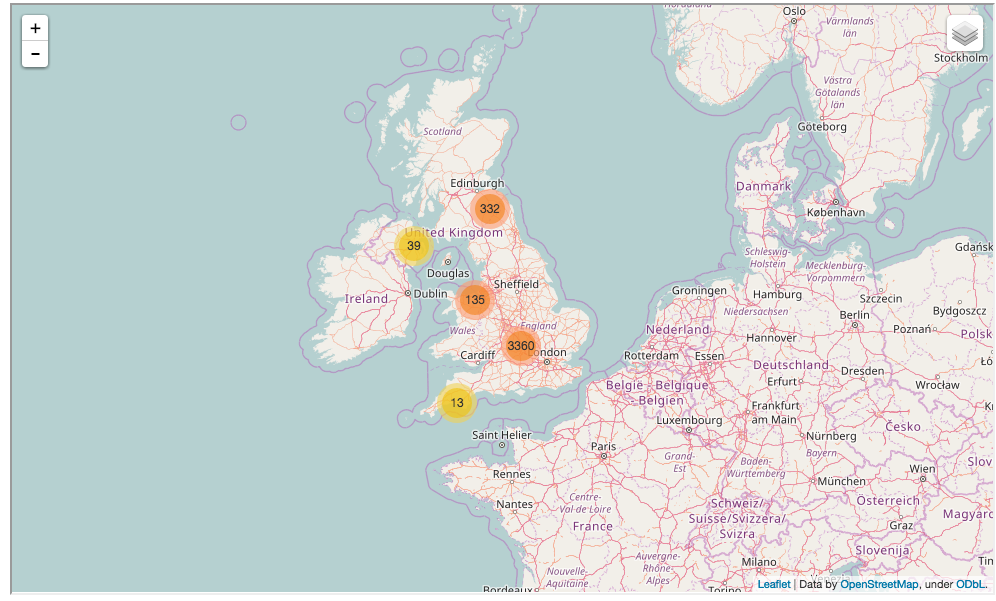

In [70]:
from IPython.display import Image
Image(filename='cluster_map_0.png',width=500, height=100)

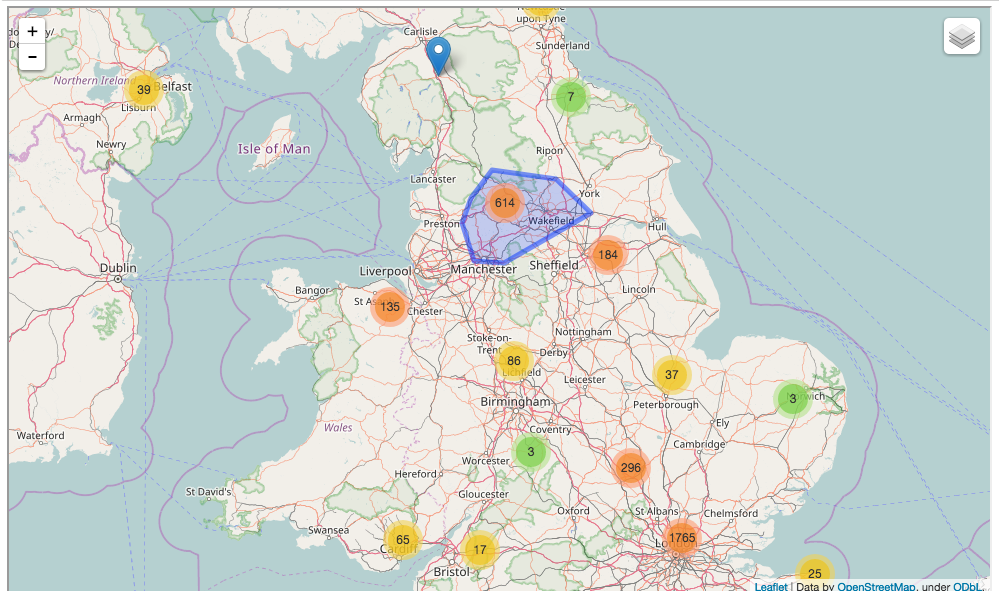

In [71]:
from IPython.display import Image
Image(filename='cluster_map_1.png',width=500, height=100)

- Heat map layer

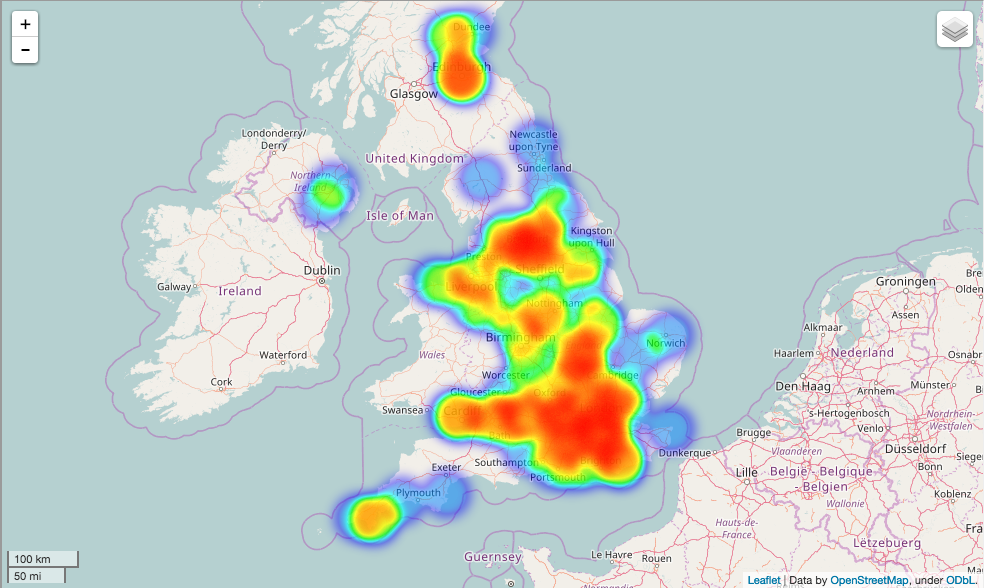

In [72]:
from IPython.display import Image
Image(filename='heat_map_0.png',width=500, height=100)

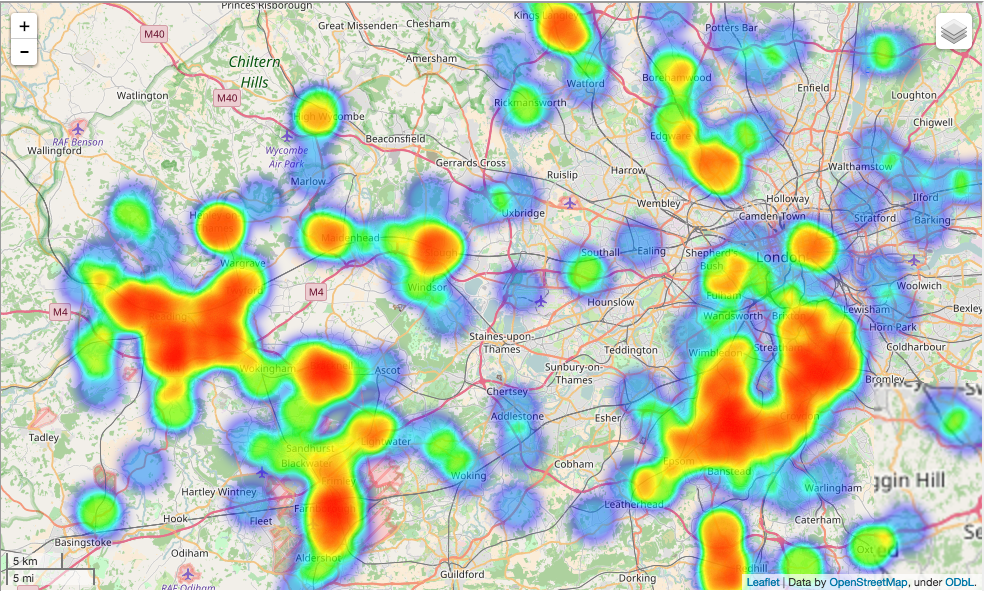

In [73]:
from IPython.display import Image
Image(filename='heat_map_1.png',width=500, height=100)

<a id='Feature_analysis'></a>
***
## Feature analysis
***

### Feature creation
- combine features into more descriptive quantities 
  and define non linear combination of features which may help exploit higher order correlations:
     - first: for convenience, express time range variables in minutes
     - calculate effective driving time  and trip average speed  
      $t_{drive}=t_{duration}-t_{idle}$  
      $v_{ave}=\frac{d}{t_{drive}}$  
      where $d$ is the obd measured distance
     - compute total number of $hard$ $drive$ $maneuvers$ per trip as the sum hard accelerations and brakes  
      $N_{hm} = N_{acc}+N_{brake}$
     - for each trip, compute number of hard maneuvers per mile: $N_{hm}/d$

In [74]:
# convert seconds to minutes
pdf.rename(columns={'duration_seconds':'duration','idle_seconds':'idle'}, inplace = True)
pdf['duration'] = pdf.eval('duration/60.')
pdf['idle'] = pdf.eval('idle/60.')

# effective driven time
pdf['drive_time'] = pdf.eval('duration - idle')

# mph 
pdf['ave_speed'] = pdf.eval('60.*(obd_distance/drive_time)')

# hard maneuvers
pdf['hard_manv_count'] = pdf.eval('hard_accel_count + hard_brake_count')

#  hard maneuvers per mile (distance has been already validated to be always >0)
pdf['hard_manv_pm'] = pdf.eval('hard_manv_count/obd_distance')


- Add one more distance-like variable: geo_distance
        - geodesic distance (i.e. the shortest) between start-point and end-point of a trip may capture other
          feature charateristic, in addition to the effective driven distance (obd_distance)

In [75]:
# calculate geo-distance from lat/lon coordinates
import geopy
from geopy.distance import vincenty

def getGeoDist(row):
    start = (row['start_point_lat'],row['start_point_lon'])
    end   = (row['end_point_lat'],row['end_point_lon'])
    return vincenty(start,end).miles

pdf['geo_distance'] = pdf.apply(getGeoDist, axis=1)


- reshuffle columns to group them by subject

In [76]:
columns = ['device_id', 'vehicle_nickname', 'start_point_city' \
       ,'start_point_state', 'start_point_zipcode', 'start_point_lat' \
       ,'start_point_lon', 'start_point_timestamp', 'end_point_city' \
       ,'end_point_state', 'end_point_zipcode', 'end_point_lat', 'end_point_lon' \
       ,'end_point_timestamp', 'duration','idle','drive_time' \
       ,'gps_distance','obd_distance','geo_distance' \
       ,'top_speed','ave_speed' \
       ,'hard_accel_count', 'hard_brake_count','hard_manv_count', 'hard_manv_pm'\
       ,'points_city_count', 'points_hwy_count', 'speeding_city_major_count' \
       ,'speeding_city_minor_count', 'speeding_hwy_major_count' \
       ,'speeding_hwy_minor_count']

In [77]:
pdf = pdf[columns]
pdf.head()

device_id vehicle_nickname start_point_city start_point_state  \
0  37         bens             London           England            
1  37         bens             London           England            
2  37         bens             London           England            
3  37         bens             London           England            
4  37         bens             London           England            

  start_point_zipcode  start_point_lat  start_point_lon start_point_timestamp  \
0  SE22 0NN           51.45408         -0.05773         2016-08-10 17:33:52     
1  SE20 8SJ           51.40570         -0.06566         2016-08-13 09:00:25     
2  SE6 4RS            51.43126         -0.03489         2016-08-13 10:41:20     
3  SE20 8SH           51.40616         -0.06565         2016-08-14 00:53:25     
4  SE20 8SH           51.40576         -0.06559         2016-08-17 19:27:08     

  end_point_city end_point_state end_point_zipcode  end_point_lat  \
0  London         England         SE20 8SH         51.40580         
1  London         England         SE6 4RS          51.43126         
2  London         England         SE20 8SH         51.40581         
3  London         England         SE20 8SW         51.40634         
4  Orpington      England         BR6 0AT          51.37328         

   end_point_lon end_point_timestamp  duration     idle  drive_time  \
0 -0.06562       2016-08-10 17:55:50 21.96667  6.00000  15.96667      
1 -0.03489       2016-08-13 09:13:16 12.85000  3.15000  9.70000       
2 -0.06558       2016-08-13 10:54:48 13.46667  3.56667  9.90000       
3 -0.06818       2016-08-14 01:01:18 7.88333   1.73333  6.15000       
4 0.09562        2016-08-17 20:00:46 33.63333  10.08333 23.55000      

   gps_distance  obd_distance  geo_distance  top_speed  ave_speed  \
0 4.56465       4.49189       3.35521       41.60000   16.87976     
1 2.26938       2.81295       2.21154       32.30000   17.39967     
2 2.21226       2.72223       2.20356       29.80000   16.49835     
3 0.11582       1.40492       0.10999       28.00000   13.70654     
4 9.23671       9.05462       7.32516       39.10000   23.06910     

   hard_accel_count  hard_brake_count  hard_manv_count  hard_manv_pm  \
0  0                 3                 3               0.66787         
1  0                 0                 0               0.00000         
2  0                 0                 0               0.00000         
3  0                 0                 0               0.00000         
4  0                 1                 1               0.11044         

   points_city_count  points_hwy_count  speeding_city_major_count  \
0  47                 0                 0                           
1  5                  0                 0                           
2  6                  0                 0                           
3  3                  0                 0                           
4  61                 0                 1                           

   speeding_city_minor_count  speeding_hwy_major_count  \
0  1                          0                          
1  0                          0                          
2  0                          0                          
3  0                          0                          
4  1                          0                          

   speeding_hwy_minor_count  
0  0                         
1  0                         
2  0                         
3  0                         
4  0

 - Tot. number of rows at this point

In [78]:
pdf.shape[0]

3879

### Feature validation  
   - Make sense of feature distribution and relations  
   - Perform data selection: remove outliers, inconsistent entries, ...

- ***Hard accel and hard brake counts***  
    for about 65$\%$ of the trips no hard accelerations or brakes are  
    registered. Ditribution falls quite rapidly for higher counts

In [79]:
print(' counts of hard accelerations+brakes, as a fraction of the total: ')
(pdf['hard_manv_count'].value_counts()/pdf.shape[0]).head()

 counts of hard accelerations+brakes, as a fraction of the total: 


0   0.66228
1   0.19309
2   0.06419
3   0.03145
4   0.01830
Name: hard_manv_count, dtype: float64

<a id='hard_manv_hist'></a>

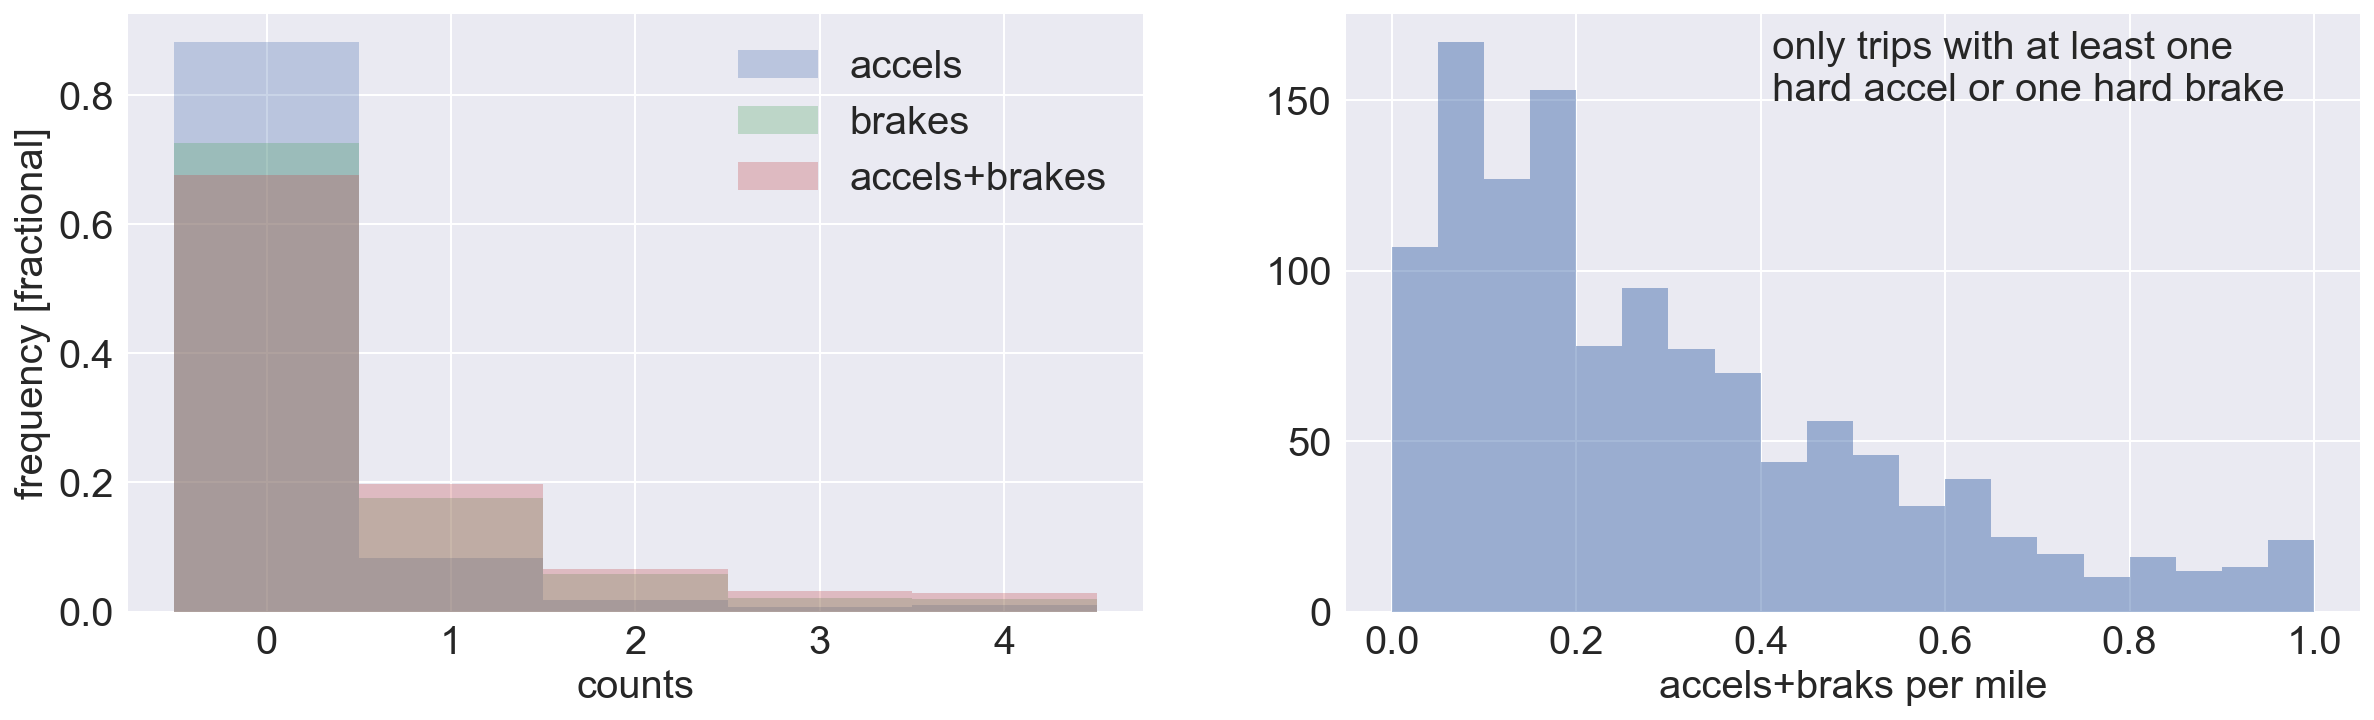

In [80]:
# 
fig, ax = plt.subplots(1,2,figsize=(20,5.5));

# superimpose three distributions, normalized to show the
# relative frequency of each count
args = dict(bins=5, range=(0,5), normed=True, alpha=0.3, align='left'); #opts

ax[0].hist(pdf.hard_accel_count, label='accels', **args);
ax[0].hist(pdf.hard_brake_count, label='brakes', **args);
ax[0].hist(pdf.hard_manv_count,  label='accels+brakes',**args);
ax[0].set_xlabel('counts')
ax[0].set_ylabel('frequency [fractional]')
ax[0].legend();

# blank second panel
#ax[1].axis('off');
ax[1].hist(pdf[pdf.hard_manv_count>0].hard_manv_pm,bins=20, range=(0,1), alpha=0.5);
ax[1].set_xlabel('accels+braks per mile')
ax[1].text(0.4,150,' only trips with at least one \n hard accel or one hard brake')

  - ***distances***  
    Inspect correlation plots between the three distances available.  
    For a given trip it is expected that the covered distance is always larger than the geo-distance between the  
    starting point and the end point.  
    Can be oserved that:  
    For a small number of trips the OBD distance is shorter than the geo-distance.  
    For a quite large number of trips the GPS distance is shorter than the geo-distance.  
    In both cases this is seen mostly for short trips, an indication that the cause could be  
    GPS miscalculation and/or GPS precision.  
    Moreover, difference between OBD and GPS measurement can be quite large.  
    Such results justify the usage of the OBD distance as the default measured trip length.
    

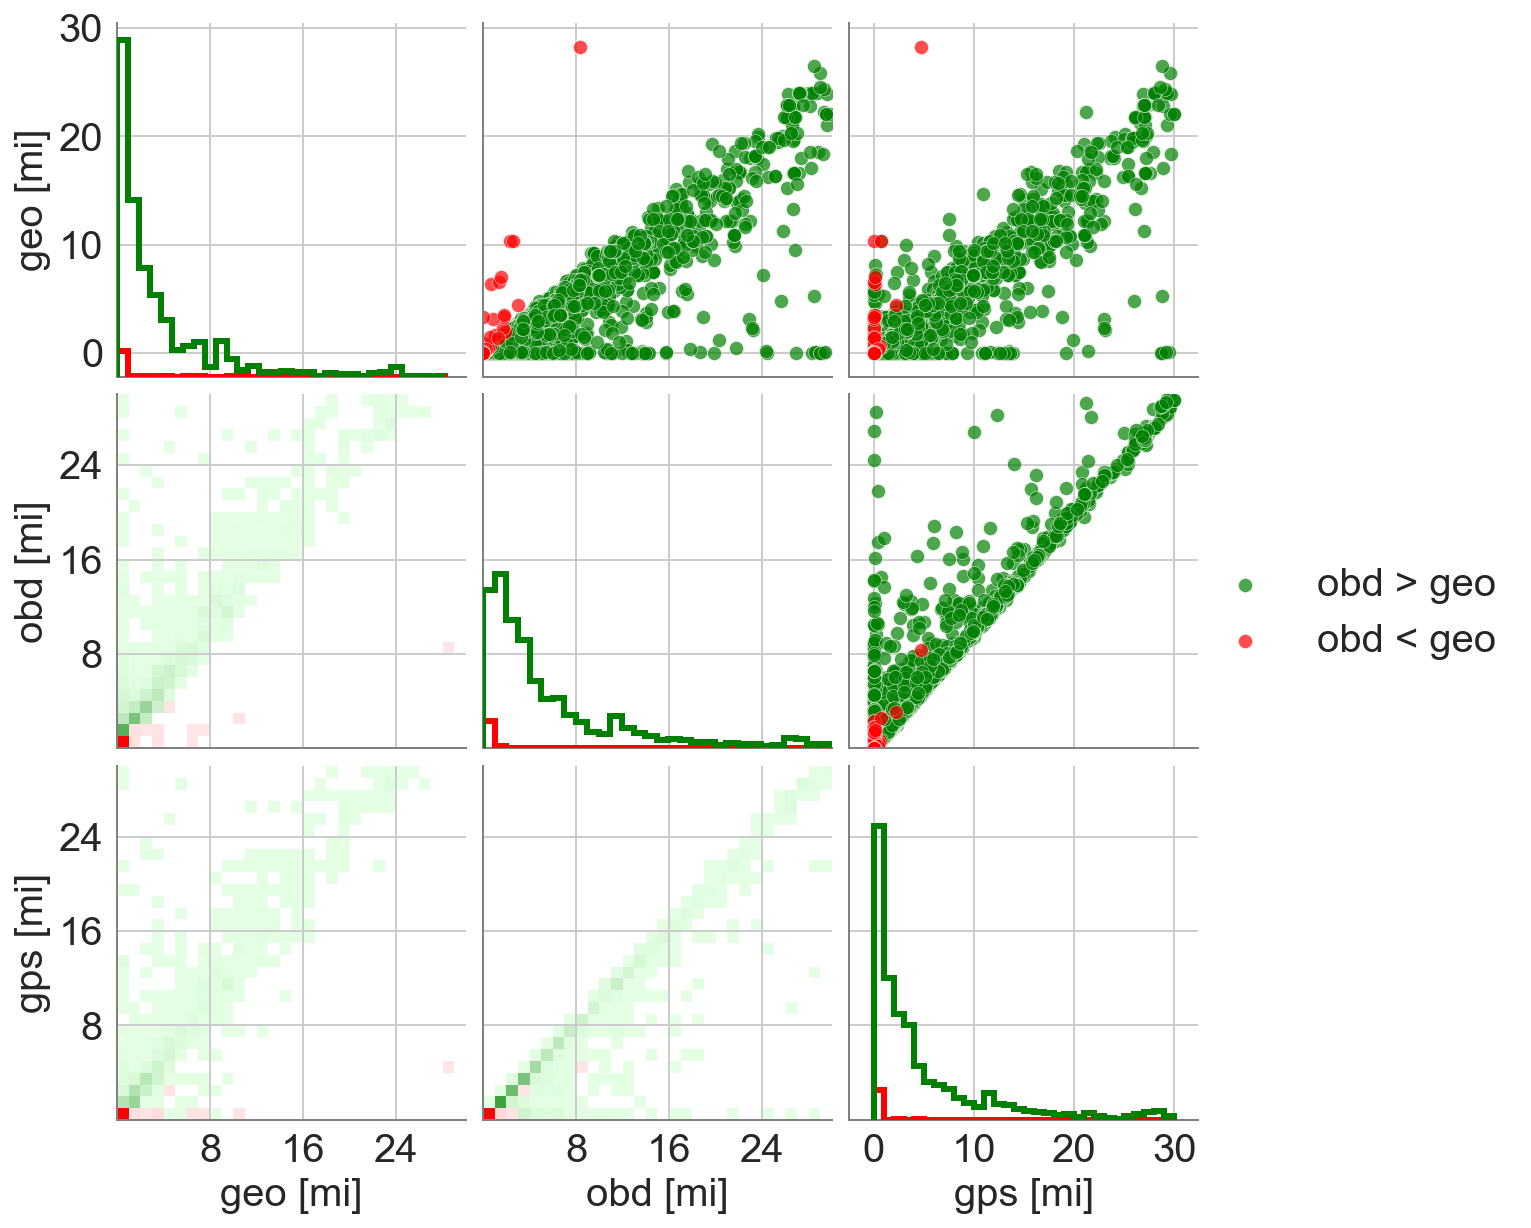

In [81]:
# keep only nedeed features
vars = ['geo_distance','obd_distance','gps_distance']

data = pdf[vars]


# some data selection for better visualization
dmax= 30

data = data[ (data.gps_distance<dmax) & (data.obd_distance<dmax) & (data.geo_distance<dmax) ]

# flag trips based on the condition on obd and geo distance 
hue = ['','obd > geo','obd < geo'] #[legend title,items...]
data[hue[0]] = (data.obd_distance > data.geo_distance).apply(lambda x: hue[1] if x else hue[2])


# prepare for visualization 
data.columns = ['geo [mi]', 'obd [mi]','gps [mi]',hue[0]]

sns.set_style('whitegrid', {'axes.edgecolor': '0.5'})


g = sns.PairGrid(data, hue=hue[0], size=3, palette={hue[1]:'g',hue[2]:'r'})

# histo on diagonal
g = g.map_diag(plt.hist, bins=30, histtype="step", linewidth=3)


# scatter on the upper side
g = g.map_upper(plt.scatter, alpha=0.7, edgecolor="w")

# heatmaps (2d-histograms) on the lower side (useful to visualize data clusterization)
# Add plt.histo2d into the sns PairGrid API it's not straightforward
# The plt.histo2d API is not fully compatible with PairGrid
# because it doesn't know how to handle a color= kwarg. 
# It is necessary to use a thin wrapper function.
def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)
    

g.map_lower(pairgrid_heatmap, bins=(np.linspace(0,dmax,dmax+1),np.linspace(0,dmax,dmax+1)))

#
g = g.add_legend()

# adjust number of ticks and avoid overlaps
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(4, prune="both"))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4, prune="both"))
    
# adjust subplots spacing
g.fig.subplots_adjust(hspace=.05, wspace=.05);

In [82]:
print(' num. of trips where gps distance <=  geo distance: {}/{} '.format(
          pdf[pdf['gps_distance'] <= pdf['geo_distance']].shape[0], pdf.shape[0] )
     )

#show data
pdf[pdf['gps_distance'] < pdf['geo_distance']].head()

 num. of trips where gps distance <=  geo distance: 514/3879 


device_id vehicle_nickname start_point_city start_point_state  \
12  37         bens             Beckenham        England            
18  37         bens             Beckenham        England            
37  6          Bill's Honda     Sutton           England            
65  37         bens             Croydon          England            
67  37         bens             London           England            

   start_point_zipcode  start_point_lat  start_point_lon  \
12  BR3 4EH            51.40113         -0.05232           
18  BR3 4AA            51.39754         -0.04958           
37  SM1 3RD            51.36700         -0.17840           
65  SE25               51.39001         -0.08990           
67  SE20 8SH           51.40589         -0.06566           

   start_point_timestamp end_point_city end_point_state end_point_zipcode  \
12 2016-08-23 07:27:33    Beckenham      England         BR3 4EA            
18 2016-08-28 12:01:19    London         England         SE20 8SH           
37 2016-09-05 12:34:10    Sutton         England         SM1 3RD            
65 2016-09-10 18:03:17    London         England         SE20 8SJ           
67 2016-09-11 11:13:31    Croydon        England         CR0 2DJ            

    end_point_lat  end_point_lon end_point_timestamp  duration    idle  \
12 51.40072       -0.05150       2016-08-23 07:33:51 6.30000   2.11667   
18 51.40579       -0.06561       2016-08-28 12:09:24 8.08333   1.91667   
37 51.36703       -0.17853       2016-09-05 12:34:58 0.80000   0.48333   
65 51.40584       -0.06578       2016-09-10 18:12:12 8.91667   2.58333   
67 51.38809       -0.08958       2016-09-11 11:22:21 8.83333   2.06667   

    drive_time  gps_distance  obd_distance  geo_distance  top_speed  \
12 4.18333     0.04361       1.17626       0.04541       29.20000     
18 6.16667     0.01975       1.61246       0.89738       28.60000     
37 0.31667     0.00411       0.00497       0.00592       3.10686      
65 6.33333     0.03999       1.63607       1.51158       37.30000     
67 6.76667     0.01172       1.67584       1.60733       27.30000     

    ave_speed  hard_accel_count  hard_brake_count  hard_manv_count  \
12 16.87060    0                 1                 1                 
18 15.68878    0                 0                 0                 
37 0.94187     0                 0                 0                 
65 15.49961    0                 0                 0                 
67 14.85965    0                 0                 0                 

    hard_manv_pm  points_city_count  points_hwy_count  \
12 0.85016        2                  0                  
18 0.00000        3                  0                  
37 0.00000        1                  0                  
65 0.00000        3                  0                  
67 0.00000        3                  0                  

    speeding_city_major_count  speeding_city_minor_count  \
12  0                          0                           
18  0                          0                           
37  0                          0                           
65  0                          0                           
67  0                          0                           

    speeding_hwy_major_count  speeding_hwy_minor_count  
12  0                         0                         
18  0                         0                         
37  0                         0                         
65  0                         0                         
67  0                         0

In [83]:
print(' num. of trips where obd distance <=  geo distance: {}/{} '.format(
          pdf[pdf['obd_distance'] <= pdf['geo_distance']].shape[0],pdf.shape[0] )
     )

#show data
pdf[pdf['obd_distance'] < pdf['geo_distance']].head()

 num. of trips where obd distance <=  geo distance: 111/3879 


device_id vehicle_nickname start_point_city start_point_state  \
37   6          Bill's Honda     Sutton           England            
155  40         ov54phj          Stoke            England            
233  20         L3TGG            Four Marks       England            
238  5          W31PMW           Perth            Scotland           
267  40         ov54phj          Stoke            England            

    start_point_zipcode  start_point_lat  start_point_lon  \
37   SM1 3RD            51.36700         -0.17840           
155  ST6                53.06413         -2.21262           
233  GU34 5DG           51.10756         -1.04513           
238  PH1 3UN            56.41909         -3.47579           
267  ST1 6BG            53.03754         -2.16995           

    start_point_timestamp end_point_city end_point_state end_point_zipcode  \
37  2016-09-05 12:34:10    Sutton         England         SM1 3RD            
155 2016-09-17 10:25:14    Stoke          England         ST6                
233 2016-09-18 14:17:53    Four Marks     England         GU34 5DG           
238 2016-09-18 14:56:41    Perth          Scotland        PH1 3ED            
267 2016-09-19 09:48:50    Stoke          England         ST1 6BG            

     end_point_lat  end_point_lon end_point_timestamp  duration    idle  \
37  51.36703       -0.17853       2016-09-05 12:34:58 0.80000   0.48333   
155 53.06408       -2.21259       2016-09-17 10:27:17 2.05000   1.63333   
233 51.10756       -1.04523       2016-09-18 14:19:06 1.21667   0.73333   
238 56.41898       -3.47600       2016-09-18 14:57:19 0.63333   0.00000   
267 53.03752       -2.16990       2016-09-19 09:55:28 6.63333   6.61667   

     drive_time  gps_distance  obd_distance  geo_distance  top_speed  \
37  0.31667     0.00411       0.00497       0.00592       3.10686      
155 0.41667     0.00706       0.00186       0.00380       2.50000      
233 0.48333     0.00408       0.00373       0.00414       3.10686      
238 0.63333     0.00881       0.00186       0.01133       3.72823      
267 0.01667     0.00331       0.00000       0.00269       0.00000      

     ave_speed  hard_accel_count  hard_brake_count  hard_manv_count  \
37  0.94187     0                 0                 0                 
155 0.26843     0                 0                 0                 
233 0.46281     0                 0                 0                 
238 0.17660     0                 0                 0                 
267 0.00000     0                 0                 0                 

     hard_manv_pm  points_city_count  points_hwy_count  \
37  0.00000        1                  0                  
155 0.00000        2                  0                  
233 0.00000        3                  0                  
238 0.00000        2                  0                  
267 nan            1                  0                  

     speeding_city_major_count  speeding_city_minor_count  \
37   0                          0                           
155  0                          0                           
233  0                          0                           
238  0                          0                           
267  0                          0                           

     speeding_hwy_major_count  speeding_hwy_minor_count  
37   0                         0                         
155  0                         0                         
233  0                         0                         
238  0                         0                         
267  0                         0

- Apply selection: assuming the obd distance is the most robust one, it is safe to 
  remove trips for which obd distance > geo distance.  This helps removing trips for which start and/or
  end point gps are not well measured and some very short trips which will be anyhow treated in the following.

In [84]:
pdf = pdf[pdf['obd_distance'] > pdf['geo_distance']]

print( 'Tot. num of rows: {}'.format(pdf.shape[0]))

Tot. num of rows: 3768


 - ***speed***     
     For a small number of trips top speed > average speed.  
     Corresponding rows are removed

In [85]:
print(' num. of trips where top speed < ave speed: {}/{} '.format(
          pdf[pdf['top_speed'] <= pdf['ave_speed']].shape[0], pdf.shape[0] )
     )

# filter out those trips
pdf = pdf[pdf['top_speed'] >  pdf['ave_speed']]

 num. of trips where top speed < ave speed: 33/3768 


In [86]:
print( 'Tot. num of rows: {}'.format(pdf.shape[0]))

Tot. num of rows: 3735


- Exploratory study of the relation between everage speed and top speed for different values of:  
    drive time, total number of accelerations+brakes (hard maneuvers), hwy points and city points.  
    Already without additional information about the actual meaning of the last two variables it is possible to conclude that:  
            - trips with high number of hard meneuvers have higher average and top speed 
            - trips with non-null highway counts show a top speed peak around highway or non-urban speed limit    
            - trips with null highway counts show a top speed peak around the city (urban areas) speed limit  
            - shorter trips are usually urban area trips  

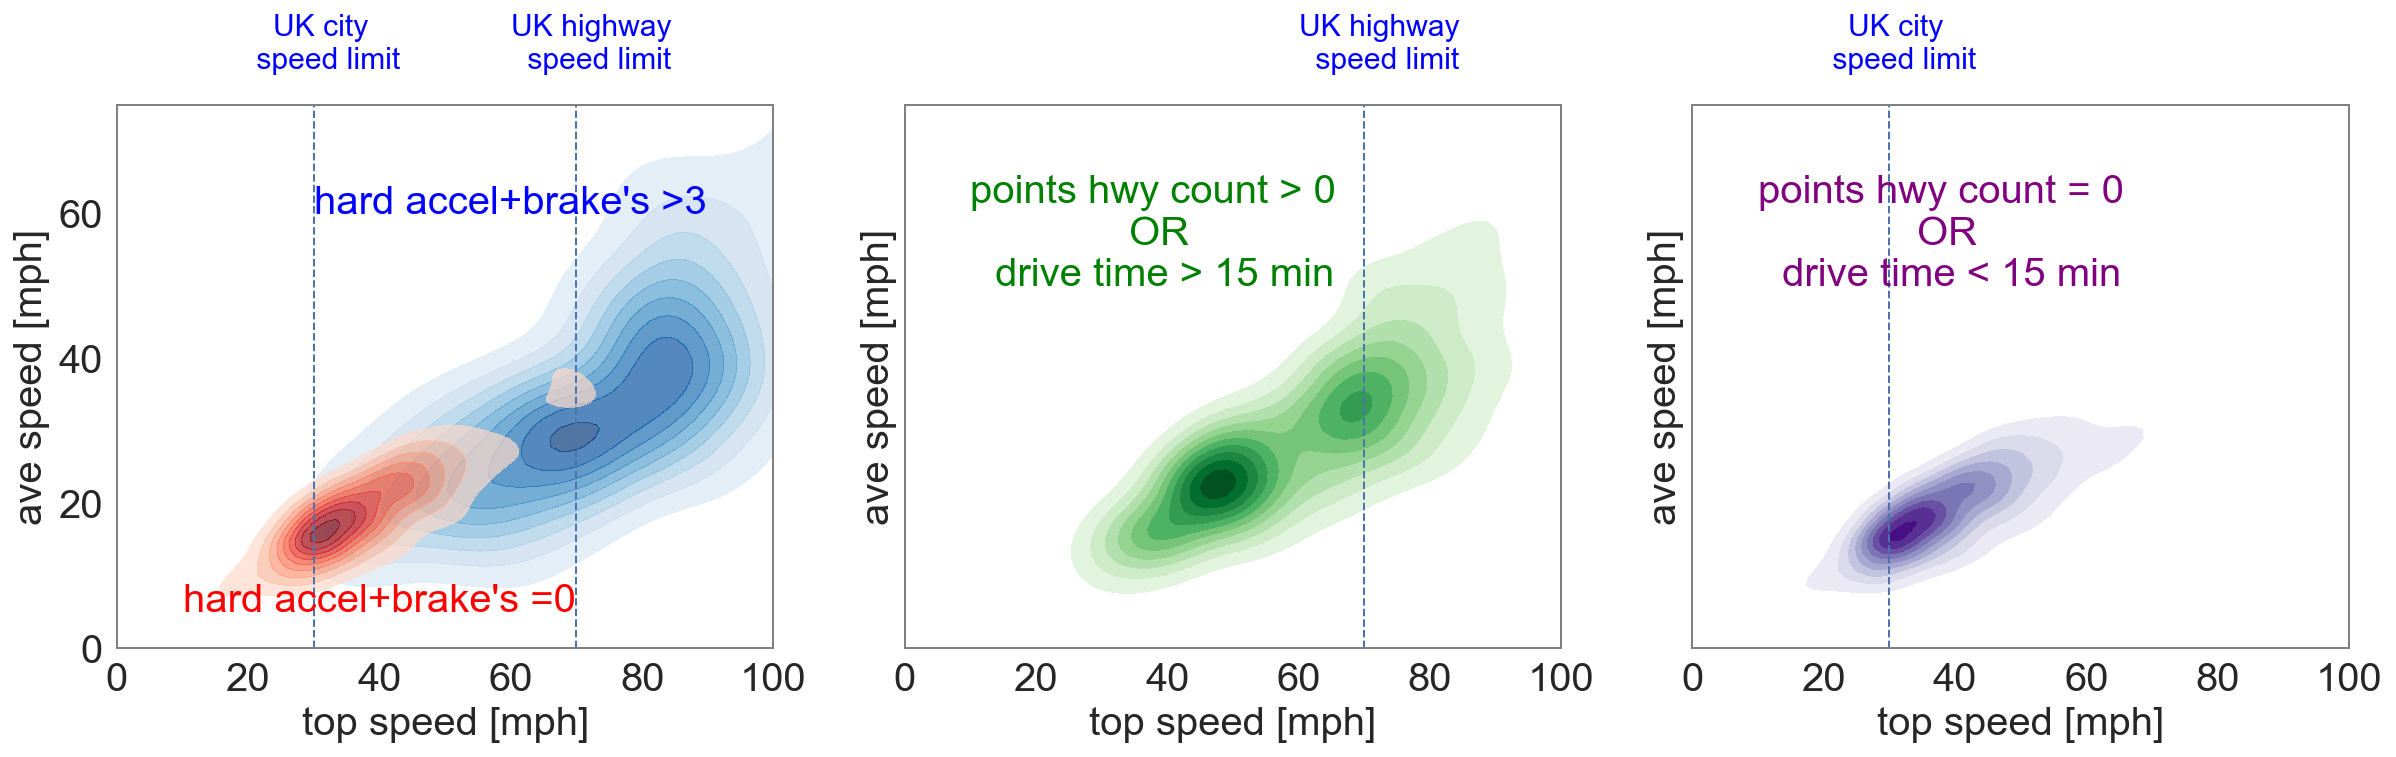

In [87]:
# features to plot
vars = ['ave_speed','top_speed','obd_distance']


# prepare data selections

data_1_1 = pdf[ pdf.hard_manv_count>3 ][vars]
data_1_2 = pdf[ pdf.hard_manv_count==0 ][vars]

data_2 = pdf[ ((pdf.drive_time>15) | (pdf.points_hwy_count>0)) ][vars]


data_3 = pdf[ ((pdf.drive_time<15) | (pdf.points_hwy_count==0)) ][vars]


# setup graphics
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True);

# first panel
#
sns.kdeplot(data_1_1.top_speed, data_1_1.ave_speed, shade=True, shade_lowest=False, cmap='Blues',alpha=0.7, ax=ax[0])
sns.kdeplot(data_1_2.top_speed, data_1_2.ave_speed, shade=True, shade_lowest=False, cmap='Reds',alpha=0.7, ax=ax[0])
ax[0].set_title('')
ax[0].set_xlabel('top speed [mph]')
ax[0].set_xlim(0,100)
ax[0].set_ylabel('ave speed [mph]')
ax[0].set_ylim(0,75)
ax[0].text(30,60,'hard accel+brake\'s >3 ',color='b', fontsize=20)
ax[0].text(10,5,'hard accel+brake\'s =0 ',color='r', fontsize=20)
ax[0].axvline(x=30, linewidth=1, linestyle='--')
ax[0].axvline(x=70, linewidth=1, linestyle='--')
ax[0].text(60,80,'UK highway \n speed limit',multialignment='center',color='b',fontsize=15)
ax[0].text(20,80,'UK city \n speed limit',multialignment='center',color='b',fontsize=15)
ax[0].grid(False)


# second panel
#
sns.kdeplot(data_2.top_speed, data_2.ave_speed, shade=True, shade_lowest=False, cmap='Greens',alpha=1, ax=ax[1])

ax[1].set_title('')
ax[1].set_xlabel('top speed [mph]')
ax[1].set_xlim(0,100)
ax[1].set_ylabel('ave speed [mph]')
ax[1].set_ylim(0,75)
ax[1].text(10,50,'points hwy count > 0 \n OR \n drive time > 15 min',multialignment='center',color='g',fontsize=20)
ax[1].axvline(x=70, linewidth=1, linestyle='--')
ax[1].text(60,80,'UK highway \n speed limit',multialignment='center',color='b',fontsize=15)
ax[1].grid(False)


# third panel
#
sns.kdeplot(data_3.top_speed, data_3.ave_speed, shade=True, shade_lowest=False, cmap='Purples', alpha=1, ax=ax[2])

ax[2].set_title('')
ax[2].set_xlabel('top speed [mph]')
ax[2].set_xlim(0,100)
ax[2].set_ylabel('ave speed [mph]')
ax[2].set_ylim(0,75)
ax[2].axvline(x=30, linewidth=1, linestyle='--')
ax[2].text(10,50,'points hwy count = 0 \n OR \n drive time < 15 min', multialignment='center',color='Purple',fontsize=20)
ax[2].text(20,80,'UK city \n speed limit',multialignment='center',color='b',fontsize=15)
ax[2].grid(False)


Comments to the plots above:  
- First panel: densities are not to scale, indeed the fraction of trips with both zero hard accel and brakes is 
much larger (see [plot](#hard_manv_hist))  
- Second panel: cluster at around 50 mph is related to the increase of the mean top speed for longer trips which are
a mixture of both city and non city rides.

### Feature Engineering
- Prepare features for ML algos, in particular the day of the week and the hour of the day

  ##### Categorical Features breakdown:

In [88]:
# define func to show categorical fields and the number of levels
def dump_categories(df):
    for col_name in df.columns:
        if df[col_name].dtypes == 'object':
            unique_cat = len(df[col_name].unique())
            print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

In [89]:
dump_categories(pdf)

Feature 'vehicle_nickname' has 55 unique categories
Feature 'start_point_city' has 352 unique categories
Feature 'start_point_state' has 4 unique categories
Feature 'start_point_zipcode' has 1305 unique categories
Feature 'end_point_city' has 363 unique categories
Feature 'end_point_state' has 4 unique categories
Feature 'end_point_zipcode' has 1361 unique categories


  ***zipcode***:  
   - There are ~1.3k different zip codes out of ~4k trips.  
   - A query to the UK postcodes web API shows that this is a 'very fine granularity' post code  
     and that the first part is the 'Area Code'
   - For this dataset it is necessary to extract only the Area Code in order to have a usable feature.   
     There are 89 different area codes.
   - New features created: start_area_zip and end_area_zip.

In [90]:
pdf[ ['start_point_zipcode','end_point_zipcode']].head(3)

start_point_zipcode end_point_zipcode
0  SE22 0NN            SE20 8SH        
1  SE20 8SJ            SE6 4RS         
2  SE6 4RS             SE20 8SH

In [91]:
print( 'toal number of trips: {}'.format(pdf.shape[0]))
print( 'num. of unique starting point zip codes: {}'.format(pdf['start_point_zipcode'].unique().shape[0]))

toal number of trips: 3735
num. of unique starting point zip codes: 1305


In [92]:
# query UK postcode web API
# use the first zipcode in the dataset
import urllib
code = pdf['start_point_zipcode'].values[0]
url = 'http://api.postcodes.io/postcodes/'+str(code)
res = urllib.urlopen(url).read()

#print results
code
url
res

'{"status":200,"result":{"postcode":"SE22 0NN","quality":1,"eastings":535064,"northings":174592,"country":"England","nhs_ha":"London","longitude":-0.0575022174614355,"latitude":51.4542065140995,"parliamentary_constituency":"Camberwell and Peckham","european_electoral_region":"London","primary_care_trust":"Southwark","region":"London","lsoa":"Southwark 029C","msoa":"Southwark 029","incode":"0NN","outcode":"SE22","admin_district":"Southwark","parish":"Southwark, unparished area","admin_county":null,"admin_ward":"Peckham Rye","ccg":"NHS Southwark","nuts":"Lewisham and Southwark","codes":{"admin_district":"E09000028","admin_county":"E99999999","admin_ward":"E05000547","parish":"E43000218","ccg":"E38000171","nuts":"UKI44"}}}'

In [93]:
# keep only literal characther of the first part of the code
from string import digits

pdf['start_area_zip']=pdf['start_point_zipcode'].apply(lambda x: str(x).split(' ')[0].translate(None,digits))
pdf['end_area_zip']=pdf['end_point_zipcode'].apply(lambda x: str(x).split(' ')[0].translate(None,digits))

# show some data
pdf[['start_point_zipcode','start_area_zip']].head(3)

start_point_zipcode start_area_zip
0  SE22 0NN            SE           
1  SE20 8SJ            SE           
2  SE6 4RS             SE

In [94]:
# find list of unique Area Codes
area_code_list = pdf['start_area_zip'].unique().tolist()
second_list    = pdf['end_area_zip'].unique().tolist()
area_code_list.extend(x for x in second_list if x not in area_code_list)

print( 'num. of unique area zip codes: {}'.format(len(area_code_list)) )

num. of unique area zip codes: 89


- Number of Area Codes is still too high.  
  Considering that 17$\%$ of the trips start in the 'RG' area
  and the second most frequent code is present ~6$\%$ of the times, it is advisable
  to group codes in just two categories (to begin with): 'RG' and 'Other'

In [95]:
# define a handy function
def get_fractional_series(s):
    """get a pd series and return a series 
    of unique values sorted by relative frequency"""
    if s.shape[0]==0:
        return s
    f = s.value_counts()
    if f.sum():
        f /= f.sum()
    return f

In [96]:
# compute relative fractions of starting area codes
fracs = get_fractional_series(pdf['start_area_zip'])
fracs.head()

RG   0.17323
EH   0.05944
GU   0.04123
DN   0.04070
HX   0.03829
Name: start_area_zip, dtype: float64

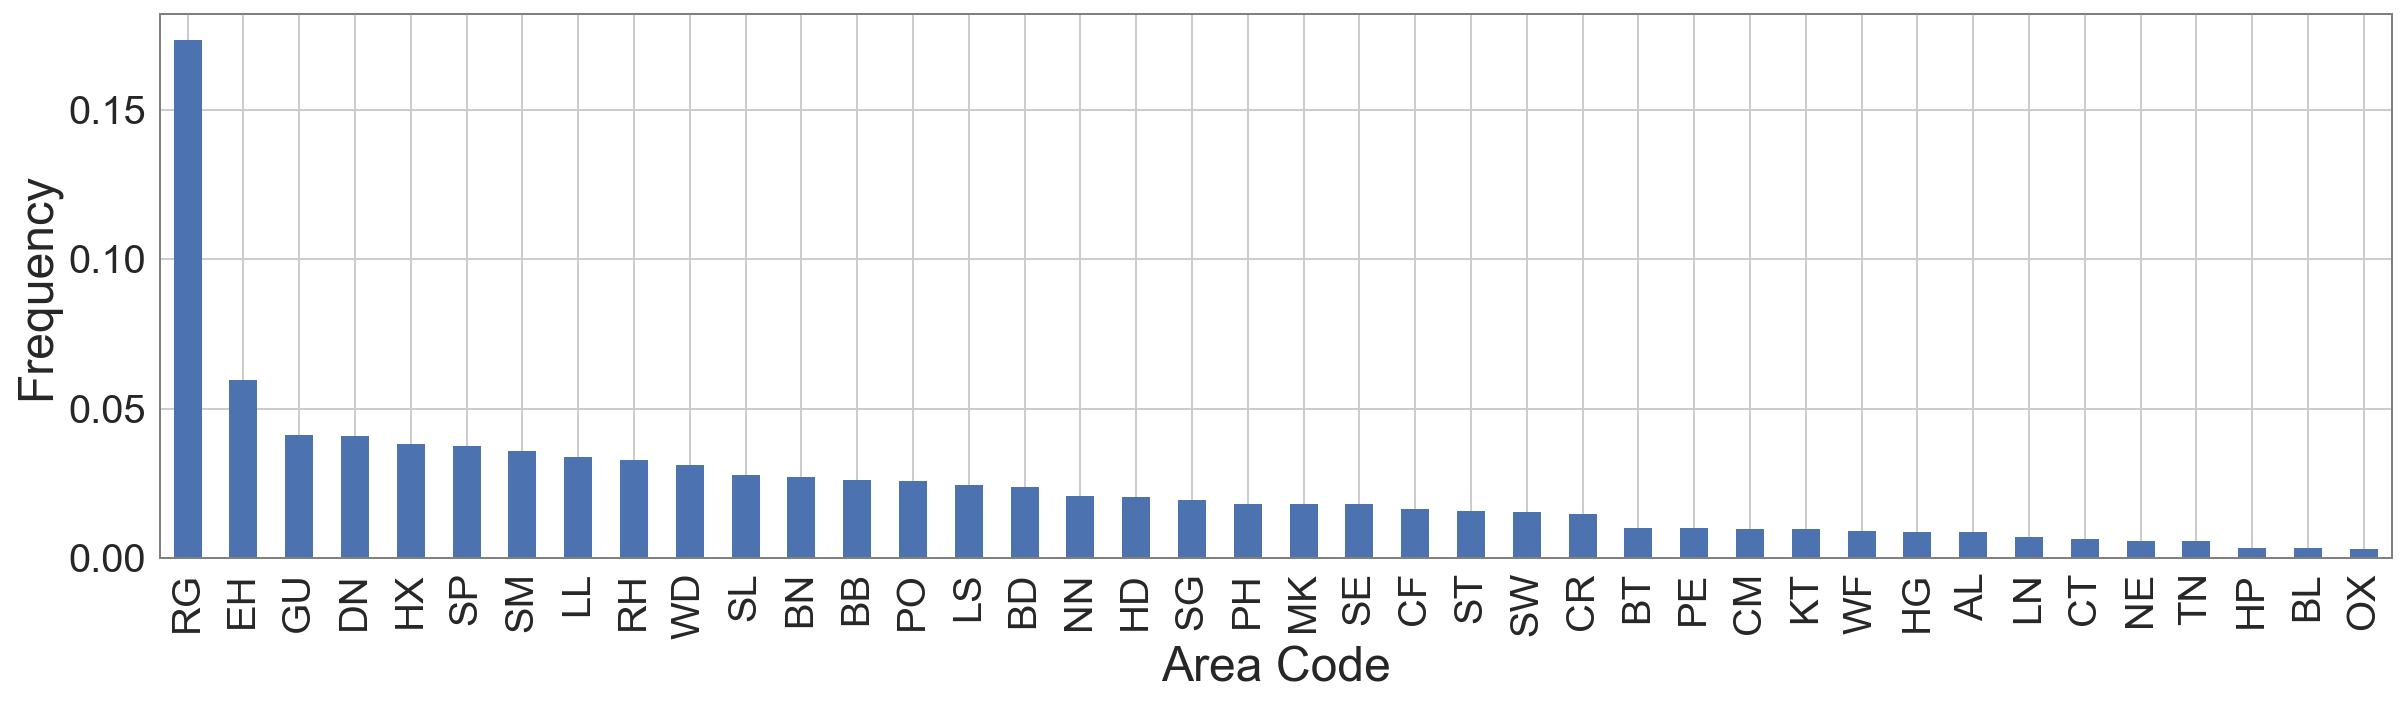

In [97]:
# plot first n entries 
ax = fracs[:40].plot(kind='bar',figsize=(20,5))
ax.set_xlabel('Area Code',fontsize=24)
ax.set_ylabel('Frequency',fontsize=24)

In [98]:
# select only the first item and group the other in the 'Other' category
code_list = fracs.index[0]

pdf['start_area_zip'] = pdf['start_area_zip'].apply(lambda x: x if x in code_list else 'Other')
pdf['end_area_zip']   = pdf['end_area_zip'].apply(lambda x: x if x in code_list else 'Other')

# cross check
print(' area code categories (levels={}): '.format(pdf['start_area_zip'].unique().shape[0]))
pdf['start_area_zip'].unique()

 area code categories (levels=2): 


array(['Other', 'RG'], dtype=object)

   ***city***: 
  - There are more than 300 different start/end point cities.  
  - Distribution of cities is quite even. In order to reduce number of categories
    cities contributing for less then 3$\%$ are binned into the category 'Other'

In [99]:
print( 'toal number of trips: {}'.format(pdf.shape[0]))
print( 'num. of unique starting point cities: {}'.format(pdf['start_point_city'].unique().shape[0]))

toal number of trips: 3735
num. of unique starting point cities: 352


In [100]:
fracs = get_fractional_series(pdf['start_point_city'])
fracs.head()

Scunthorpe   0.04043
London       0.03748
Bracknell    0.03347
Reading      0.03266
Sutton       0.02865
Name: start_point_city, dtype: float64

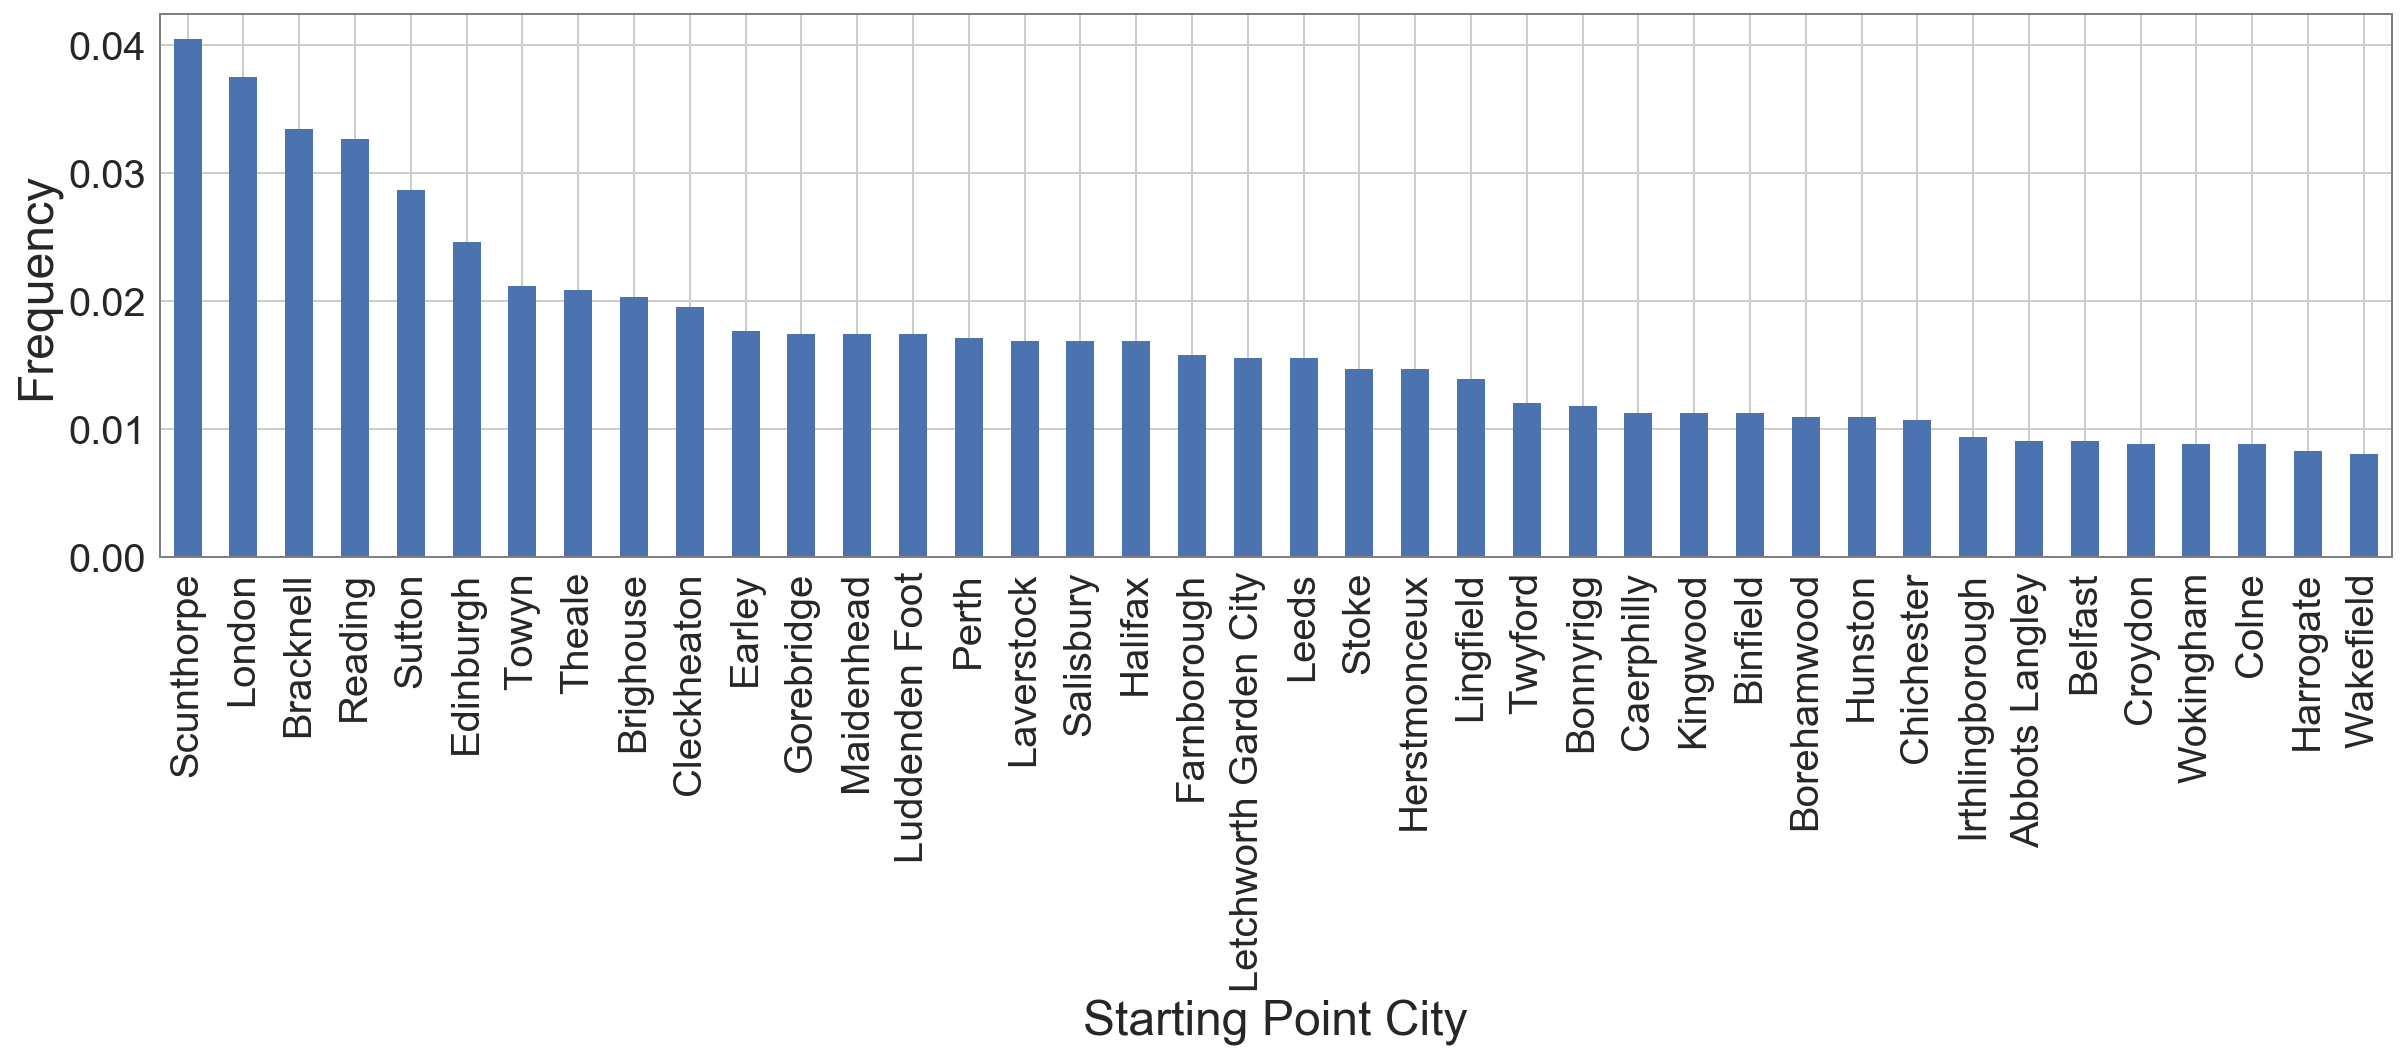

In [101]:
# plot first n entries 
ax = fracs[:40].plot(kind='bar',figsize=(20,5))
ax.set_xlabel('Starting Point City',fontsize=24)
ax.set_ylabel('Frequency',fontsize=24)

In [102]:
#
def cut_fraction(series,f,opt=None):
    """
     takes a series and returns a list of UNIQUE items for which
     the occurrence frquency higher than f
     if option='cumulative' if specified returns items contributing
     up to a fraction f of the total 
    """
    if series.shape[0]==0:
        return series
    s = series
    s.sort_values(ascending=False, inplace=True)

    if str(opt).lower()=='cumulative':
        s.cumsum()
        print('h')
        return s[s<f].index.tolist()
    else:
        return s[s>f].index.tolist()
    

In [103]:
city_list = cut_fraction(fracs, 0.03)

pdf['start_point_city'] = pdf['start_point_city'].apply(lambda x: x if x in city_list else 'Other')
pdf['end_point_city'] = pdf['end_point_city'].apply(lambda x: x if x in city_list else 'Other')

# cross check
print(' city categories (counts={}): '.format(pdf['start_point_city'].unique().shape[0]))
pdf['start_point_city'].unique()

 city categories (counts=5): 


array([u'London', 'Other', u'Reading', u'Scunthorpe', u'Bracknell'], dtype=object)

***(Timeseries) Date Time Features***: 
 - Inspect distribution of relevant quantities over time

 - Index rows with the timestamp in order to use timeseries realted utilities

In [104]:
pdf.reset_index(inplace=True)
pdf.set_index('start_point_timestamp', inplace=True)

   - Data time interval is from 2016-08-10 to 2016-12-13

In [105]:
# first two trips
pdf.head(2)

index  device_id vehicle_nickname start_point_city  \
start_point_timestamp                                                       
2016-08-10 17:33:52    0      37         bens             London            
2016-08-13 09:00:25    1      37         bens             London            

                      start_point_state start_point_zipcode  start_point_lat  \
start_point_timestamp                                                          
2016-08-10 17:33:52    England           SE22 0NN           51.45408           
2016-08-13 09:00:25    England           SE20 8SJ           51.40570           

                       start_point_lon end_point_city end_point_state  \
start_point_timestamp                                                   
2016-08-10 17:33:52   -0.05773          London         England          
2016-08-13 09:00:25   -0.06566          London         England          

                      end_point_zipcode  end_point_lat  end_point_lon  \
start_point_timestamp                                                   
2016-08-10 17:33:52    SE20 8SH         51.40580       -0.06562         
2016-08-13 09:00:25    SE6 4RS          51.43126       -0.03489         

                      end_point_timestamp  duration    idle  drive_time  \
start_point_timestamp                                                     
2016-08-10 17:33:52   2016-08-10 17:55:50 21.96667  6.00000 15.96667      
2016-08-13 09:00:25   2016-08-13 09:13:16 12.85000  3.15000 9.70000       

                       gps_distance  obd_distance  geo_distance  top_speed  \
start_point_timestamp                                                        
2016-08-10 17:33:52   4.56465       4.49189       3.35521       41.60000     
2016-08-13 09:00:25   2.26938       2.81295       2.21154       32.30000     

                       ave_speed  hard_accel_count  hard_brake_count  \
start_point_timestamp                                                  
2016-08-10 17:33:52   16.87976    0                 3                  
2016-08-13 09:00:25   17.39967    0                 0                  

                       hard_manv_count  hard_manv_pm  points_city_count  \
start_point_timestamp                                                     
2016-08-10 17:33:52    3               0.66787        47                  
2016-08-13 09:00:25    0               0.00000        5                   

                       points_hwy_count  speeding_city_major_count  \
start_point_timestamp                                                
2016-08-10 17:33:52    0                 0                           
2016-08-13 09:00:25    0                 0                           

                       speeding_city_minor_count  speeding_hwy_major_count  \
start_point_timestamp                                                        
2016-08-10 17:33:52    1                          0                          
2016-08-13 09:00:25    0                          0                          

                       speeding_hwy_minor_count start_area_zip end_area_zip  
start_point_timestamp                                                        
2016-08-10 17:33:52    0                         Other          Other        
2016-08-13 09:00:25    0                         Other          Other

In [106]:
# last two trips
pdf.tail(2)

index  device_id vehicle_nickname start_point_city  \
start_point_timestamp                                                       
2016-12-13 18:16:32    3877   37         bens             London            
2016-12-13 19:11:44    3878   48         D4EHH            Other             

                      start_point_state start_point_zipcode  start_point_lat  \
start_point_timestamp                                                          
2016-12-13 18:16:32    England           SE6 4PU            51.44081           
2016-12-13 19:11:44    England           GU16 6PX           51.30424           

                       start_point_lon end_point_city end_point_state  \
start_point_timestamp                                                   
2016-12-13 18:16:32   -0.02927          London         England          
2016-12-13 19:11:44   -0.72358          Other          England          

                      end_point_zipcode  end_point_lat  end_point_lon  \
start_point_timestamp                                                   
2016-12-13 18:16:32    SE20 8SJ         51.40582       -0.06575         
2016-12-13 19:11:44    GU14 6EN         51.27596       -0.74820         

                      end_point_timestamp  duration    idle  drive_time  \
start_point_timestamp                                                     
2016-12-13 18:16:32   2016-12-13 18:34:25 17.88333  6.78333 11.10000      
2016-12-13 19:11:44   2016-12-13 19:21:25 9.68333   1.05000 8.63333       

                       gps_distance  obd_distance  geo_distance  top_speed  \
start_point_timestamp                                                        
2016-12-13 18:16:32   1.99922       3.42438       2.88743       37.30000     
2016-12-13 19:11:44   3.29158       3.45482       2.22731       38.50000     

                       ave_speed  hard_accel_count  hard_brake_count  \
start_point_timestamp                                                  
2016-12-13 18:16:32   18.51014    0                 0                  
2016-12-13 19:11:44   24.01036    0                 1                  

                       hard_manv_count  hard_manv_pm  points_city_count  \
start_point_timestamp                                                     
2016-12-13 18:16:32    0               0.00000        2                   
2016-12-13 19:11:44    1               0.28945        28                  

                       points_hwy_count  speeding_city_major_count  \
start_point_timestamp                                                
2016-12-13 18:16:32    0                 0                           
2016-12-13 19:11:44    0                 0                           

                       speeding_city_minor_count  speeding_hwy_major_count  \
start_point_timestamp                                                        
2016-12-13 18:16:32    0                          0                          
2016-12-13 19:11:44    1                          0                          

                       speeding_hwy_minor_count start_area_zip end_area_zip  
start_point_timestamp                                                        
2016-12-13 18:16:32    0                         Other          Other        
2016-12-13 19:11:44    0                         Other          Other

   - Plot number of trips with a sampling of 1 week and 1 day.
      - Most of the data refers to November 2016, besides a spike in mid Sep
      - Day rate shows some pattern, days with higher activity are not always correlated with
        weekday or weekends
      - Sample is likely too limited to perform timeseries forecasting

In [107]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

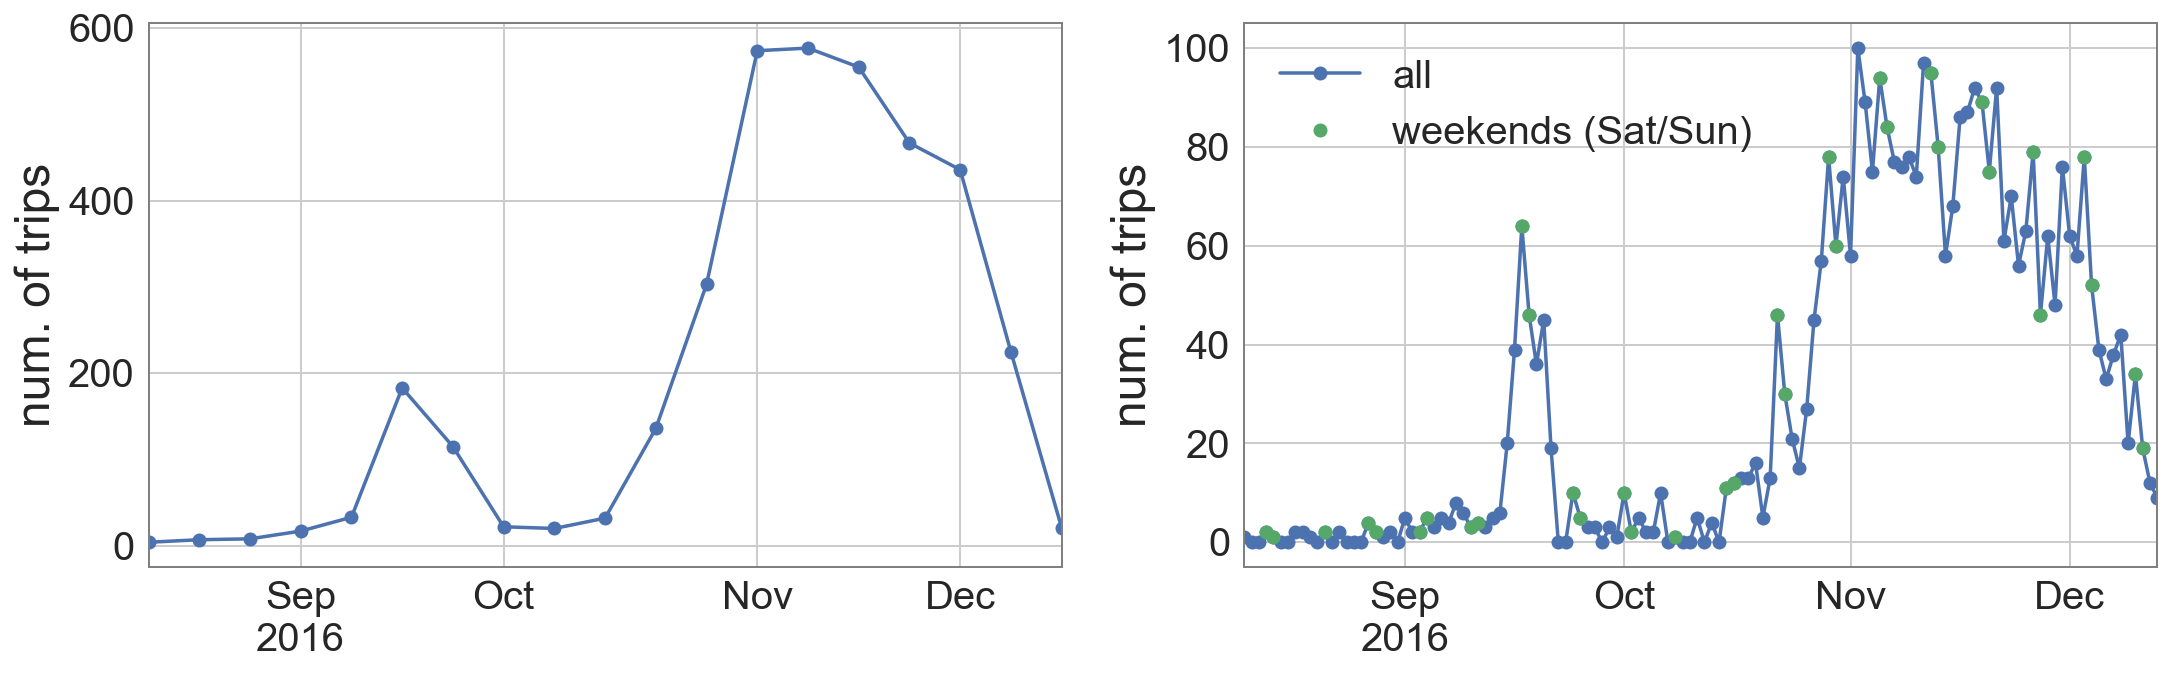

In [108]:
#
fig,ax = plt.subplots(1,2,figsize=(18,5))


# first panel
#

# resampling a 1W, count number of trips
pdf['device_id'].resample('w', how='count')\
                 .plot(kind='line',style='-o',use_index=True, ax=ax[0])
    
ax[0].set_ylabel('num. of trips', fontsize=24)
ax[0].set_xlabel('')


# second panel
#

# reamplig ad 1 day, count number of trips
pdf['device_id'].resample('1D', how='count')\
                 .plot(kind='line',style='-o',use_index=True, ax=ax[1], label='all')

# select only Saturaday and Sundays
d = pdf[pdf.index.dayofweek>=5]['device_id'].resample('1D', how='count')
d[d!=0].plot(kind='line',style='o',use_index=True, ax=ax[1], label='weekends (Sat/Sun)')


ax[1].set_ylabel('num. of trips', fontsize=24)
ax[1].set_xlabel('')
ax[1].legend()


 - More interesting could be to use the information on the day of the week and on the hour of the day
   - Produce distribution of number of trips by day of the week and by hour of the day
     - In order to reduce the number of categories, hours are grouped into three categories (shown on the plot)
     - A field is added for the day of the week 

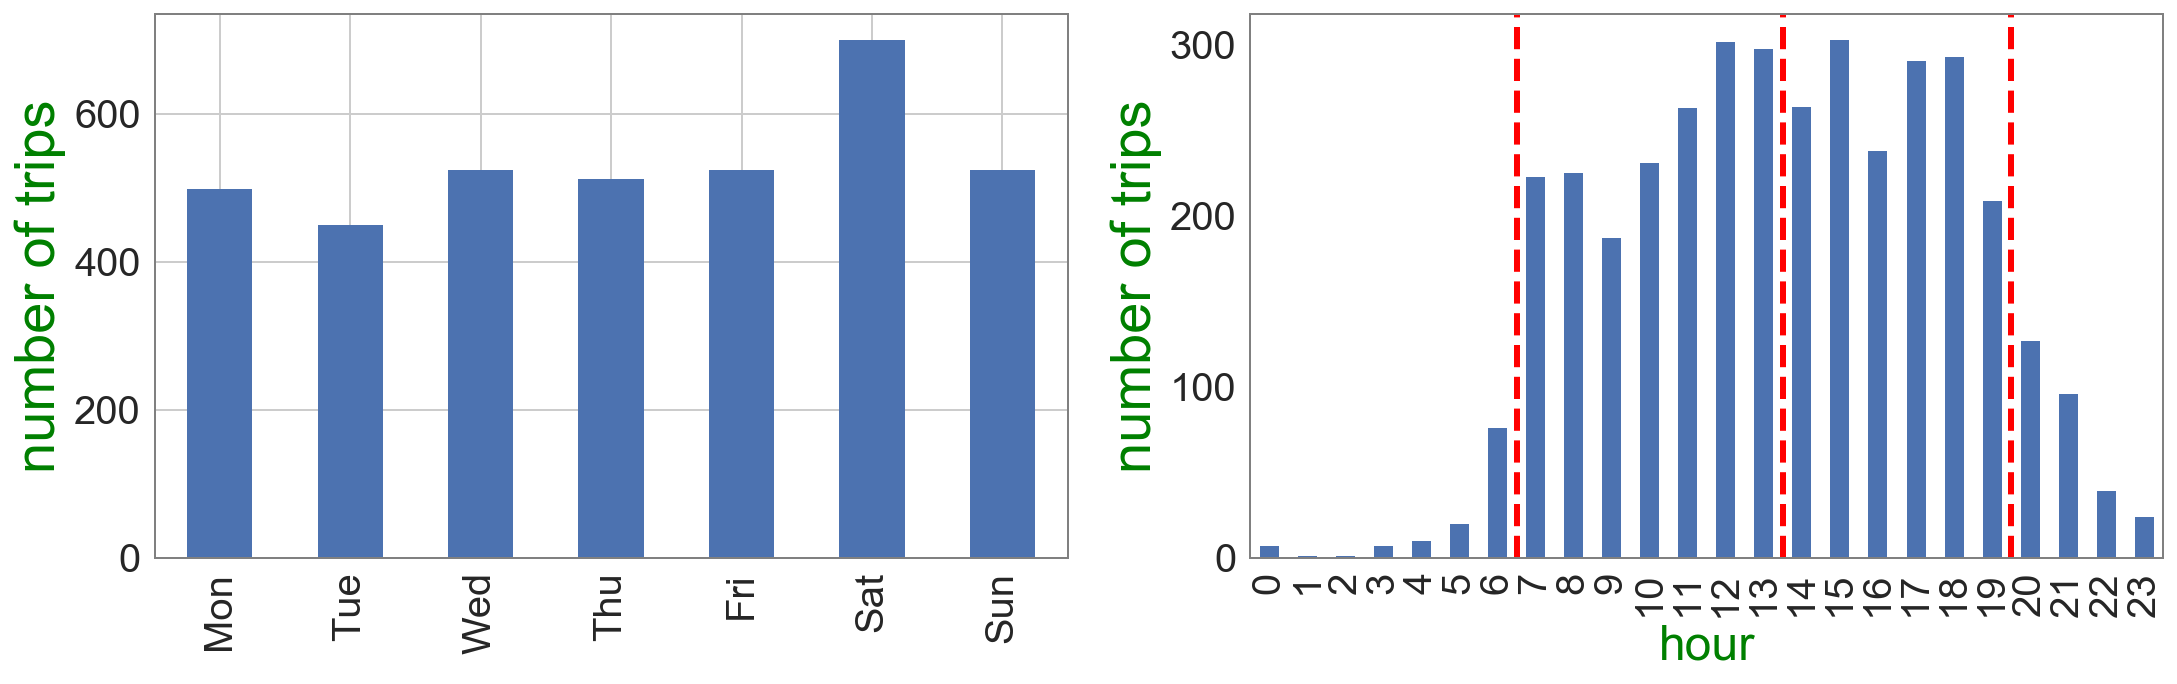

In [109]:

fig,ax = plt.subplots(1,2,figsize=(18,5))

# a little bit convolute way to show bar labels in the right order
d = pdf.groupby( [pdf.index.to_datetime().strftime('%a'), pdf.index.weekday] )\
            .count()\
            .reset_index()\
            .sort_values('level_1')\
            .set_index('level_0')['device_id']
d.plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('number of trips',color='g',fontsize=28)


# bar plot grouping by hour
d = pdf.groupby(pdf.index.hour )\
            .count()\
            ['device_id']

d.plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('hour', color='g', fontsize=24)
ax[1].set_ylabel('number of trips',color='g',fontsize=28)
ax[1].grid(False)


# based on the hour-barplot, let's divide the 24h into three categories
# draw the sepration lines
day_zones = [-0.1,6,13,19,23]

for h in day_zones[1:-1]:
    ax[1].axvline(x=h+0.5, linewidth=3, color='r', linestyle='--')


fig.subplots_adjust(hspace=.05, wspace=.2);

 - cut the datatime.hour info by the hour bins and add a categorical feature day_zone  
    (for both start and end point time)

In [110]:
# cut data
pdf['start_day_zone'] = pd.cut(pdf.index.hour, day_zones,labels=['Early','Morning','Afternoon','Night'])
# workaround as two categories wih the same name are not possible in pd.cut
pdf['start_day_zone'] = pdf['start_day_zone'].apply(lambda x: x if 'Early' not in x else 'Night')

In [111]:
# set datetime index to end_point
pdf.reset_index(inplace=True)
pdf.set_index('end_point_timestamp', inplace=True)

# apply categorization
pdf['end_day_zone'] = pd.cut(pdf.index.hour, day_zones,labels=['Early','Morning','Afternoon','Night'])
pdf['end_day_zone'] = pdf['end_day_zone'].apply(lambda x: x if 'Early' not in x else 'Night')
pdf[['end_day_zone']].head()

# reset index to start_point
pdf.reset_index(inplace=True)
pdf.set_index('start_point_timestamp', inplace=True)

In [112]:
# check results
pdf[['start_day_zone','end_point_timestamp','end_day_zone']].head()

start_day_zone end_point_timestamp end_day_zone
start_point_timestamp                                                
2016-08-10 17:33:52    Afternoon     2016-08-10 17:55:50  Afternoon  
2016-08-13 09:00:25    Morning       2016-08-13 09:13:16  Morning    
2016-08-13 10:41:20    Morning       2016-08-13 10:54:48  Morning    
2016-08-14 00:53:25    Night         2016-08-14 01:01:18  Night      
2016-08-17 19:27:08    Afternoon     2016-08-17 20:00:46  Night

In [113]:
#reset index to ordinal
pdf.reset_index(inplace=True)

#add weekday feature
pdf['start_weekday'] = pdf['start_point_timestamp'].apply(lambda x : x.to_datetime().strftime('%a') )
pdf['end_weekday'] = pdf['end_point_timestamp'].apply(lambda x : x.to_datetime().strftime('%a') )



***(Longitudinal Data) vehicle based data: ***: 
  - There are about 55 unique vehicles  
  - Produce plots, for each vehicle (over the entire time interval) of:
      - accumulated drive time 
      - total number of trips  
  - To help removing noise/outliers only vehicles with: 
      - at least 10 trips and at least 1h of accumulated drive time  
        Such selection will remove about 70 records and 10 vehicles

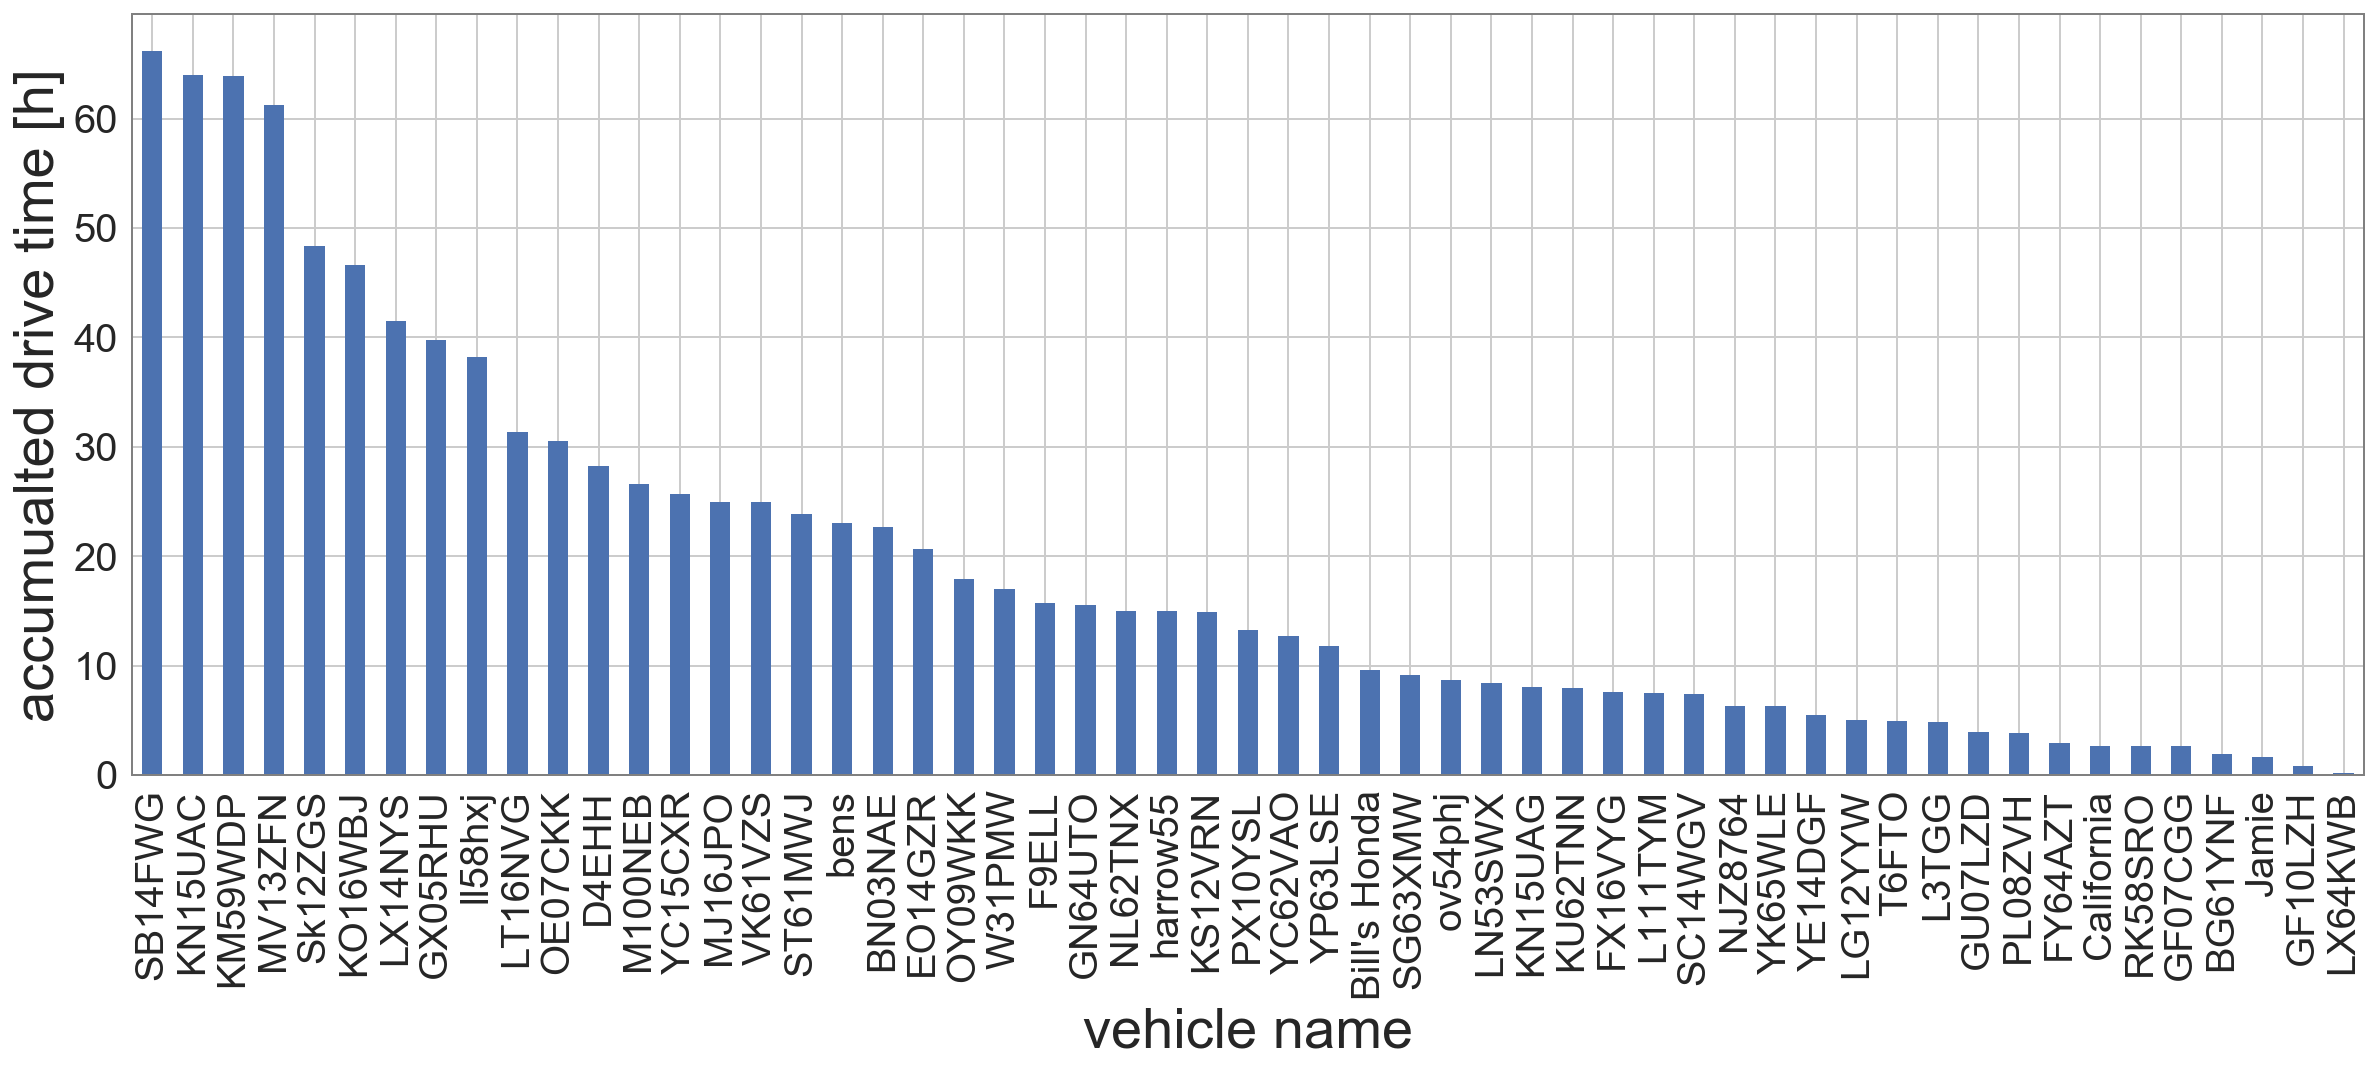

In [114]:
# 
plt = pdf.groupby(['vehicle_nickname'],as_index=True)['drive_time']\
                .sum().sort_values(ascending=False)\
                .apply(lambda x: x/60.)\
                .plot(kind='bar',figsize=(20,7)) 
    
plt.set_xlabel('vehicle name', fontsize=28)
plt.set_ylabel('accumualted drive time [h]', fontsize=28)

In [115]:
# to apply the selection it's necessary to add for each row the information about the acculated drive time
# over the entire period for the vehicle of the row
pdf['drive_time_sum'] = pdf.groupby(['vehicle_nickname'],as_index=False)['drive_time'].transform('sum')

In [116]:
print(' number of vehicles: {}'.format(pdf['vehicle_nickname'].unique().shape[0]))

 number of vehicles: 55


In [117]:
print( ' num of rows after removing vehicle with less then 2h accumulated drive time/total rows: {}/{} '.
    format(pdf[pdf['drive_time_sum']>120].shape[0], pdf.shape[0])
     )

 num of rows after removing vehicle with less then 2h accumulated drive time/total rows: 3709/3735 


In [118]:
pdf = pdf[ pdf['drive_time_sum']>120 ]

pdf.drop('drive_time_sum',axis=1,inplace=True)

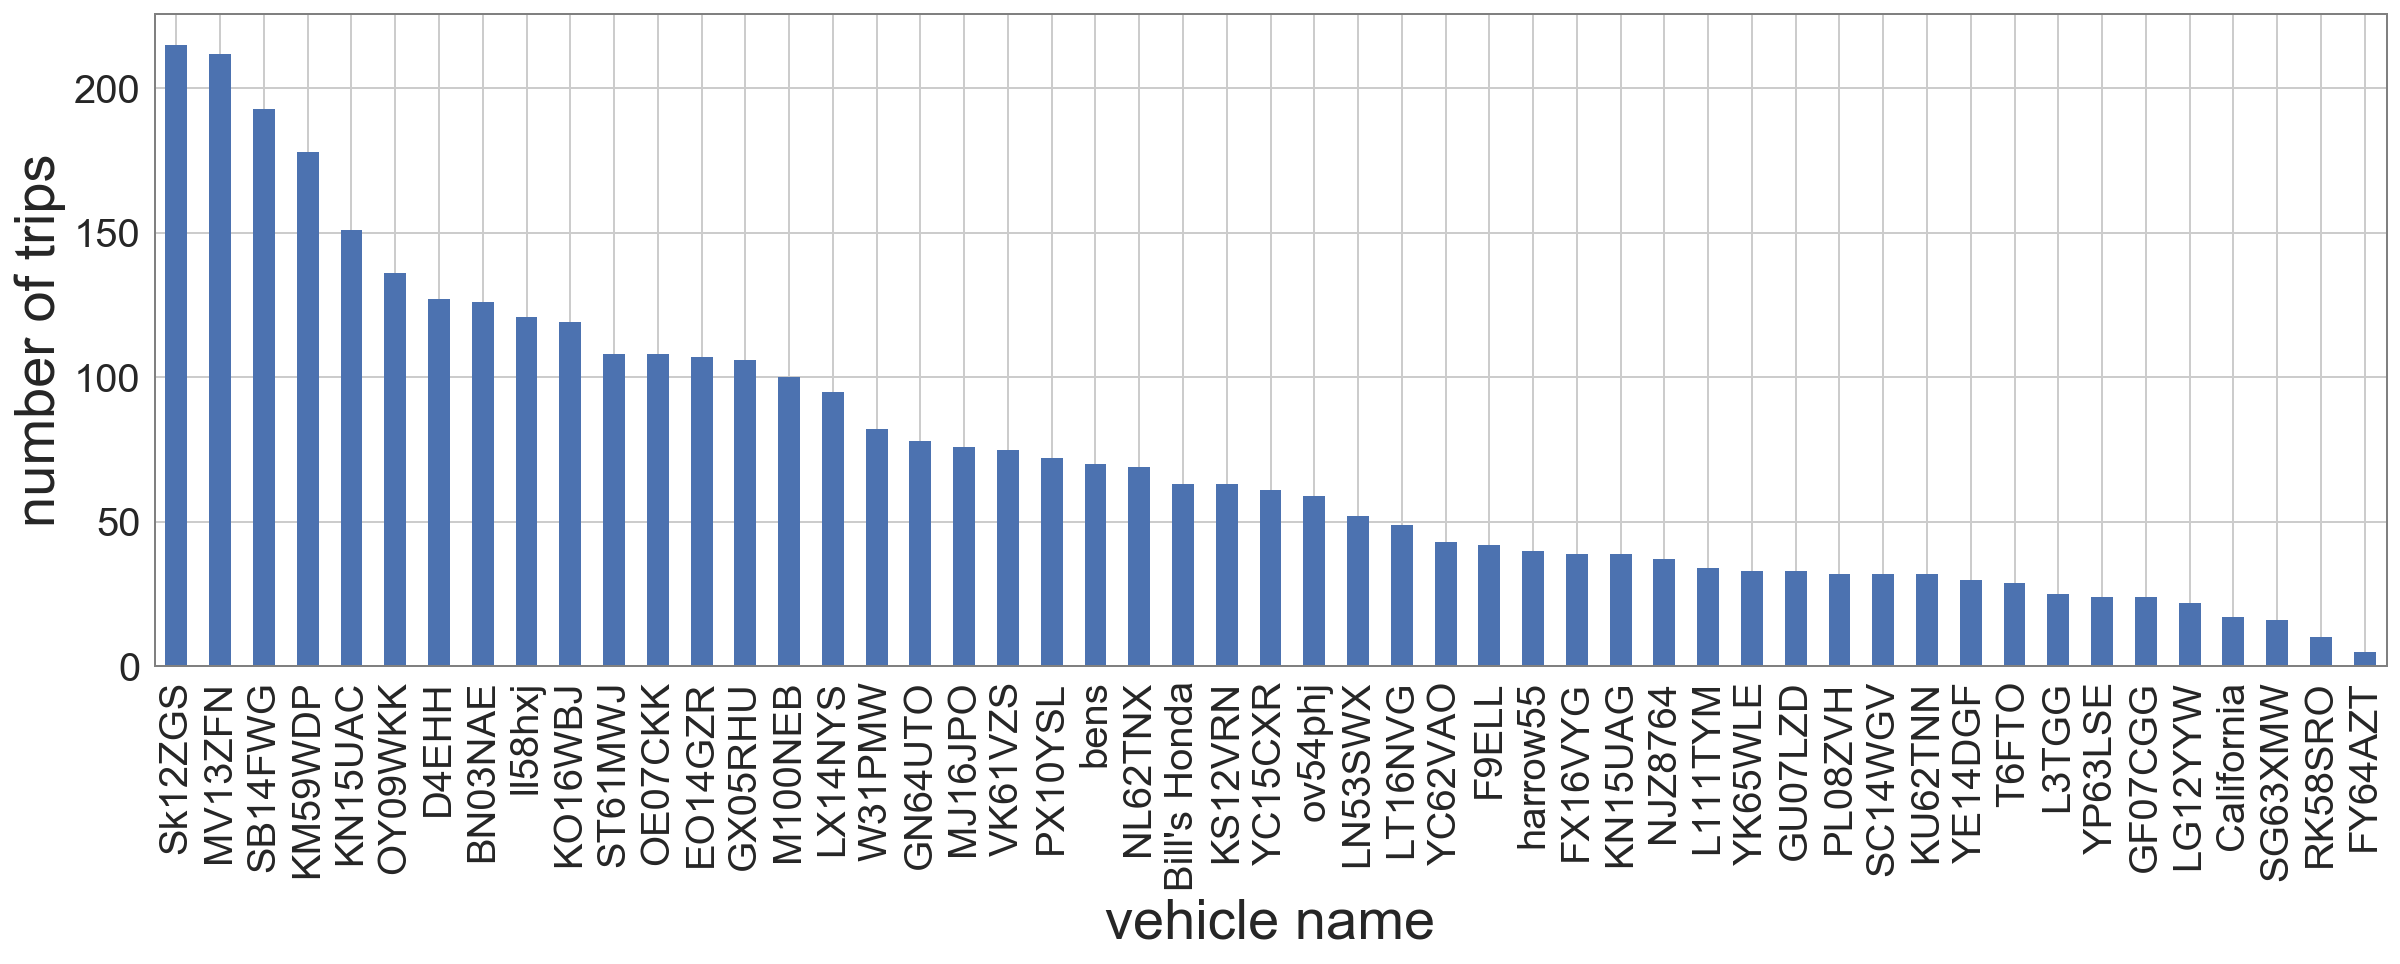

In [119]:
# 
size = pdf.groupby(['vehicle_nickname'],as_index=False).size().sort_values(ascending=False)

plt = size.plot(kind='bar',figsize=(20,6))
plt.set_xlabel('vehicle name', fontsize=28)
plt.set_ylabel('number of trips', fontsize=28)

In [120]:
# 
print(' bin values: ')
np.sort(size)

 bin values: 


array([  5,  10,  16,  17,  22,  24,  24,  25,  29,  30,  32,  32,  32,
        33,  33,  34,  37,  39,  39,  40,  42,  43,  49,  52,  59,  61,
        63,  63,  69,  70,  72,  75,  76,  78,  82,  95, 100, 106, 107,
       108, 108, 119, 121, 126, 127, 136, 151, 178, 193, 212, 215])

In [121]:
# select names of the last four
names = size.index[-4:].tolist()
print(names)

[u'California', u'SG63XMW', u'RK58SRO', u'FY64AZT']


In [122]:
# select DF rows
n = pdf.shape[0]
pdf = pdf[ ~pdf.vehicle_nickname.isin(names) ]

print( ' num of rows after removing vehicle with less then 10 trips/total rows: {}/{} '.
    format(pdf.shape[0],n)
     )

 num of rows after removing vehicle with less then 10 trips/total rows: 3661/3709 


In [123]:
print(' number of vehicles: {}'.format(pdf['vehicle_nickname'].unique().shape[0]))

 number of vehicles: 47


### Final Feature Selection. Data Structure

In [124]:
pdf.dtypes

start_point_timestamp        datetime64[ns]
end_point_timestamp          datetime64[ns]
index                        int64         
device_id                    int64         
vehicle_nickname             object        
start_point_city             object        
start_point_state            object        
start_point_zipcode          object        
start_point_lat              float64       
start_point_lon              float64       
end_point_city               object        
end_point_state              object        
end_point_zipcode            object        
end_point_lat                float64       
end_point_lon                float64       
duration                     float64       
idle                         float64       
drive_time                   float64       
gps_distance                 float64       
obd_distance                 float64       
geo_distance                 float64       
top_speed                    float64       
ave_speed                    flo

In [125]:
# list of colums with ordering
columns = [ 'vehicle_nickname'\
            #
            ,'start_point_state','start_point_city','start_area_zip'\
            ,'start_point_lat','start_point_lon'\
            ,'start_day_zone','start_weekday'\
            #
            ,'end_point_state','end_point_city','end_area_zip'\
            ,'end_point_lat','end_point_lon'\
            ,'end_day_zone','end_weekday'\
            #
            ,'top_speed','ave_speed'\
            ,'obd_distance','geo_distance'\
            ,'drive_time','idle'\
            ,'hard_manv_count'
          ]

#            #
#            ,'points_city_count','points_hwy_count'\
#            ,'speeding_city_major_count','speeding_city_minor_count'\
#            ,'speeding_hwy_major_count','speeding_hwy_minor_count'
#]

In [126]:
# extract columns
pdf = pdf[ columns ]

In [127]:
# final Data Frame shape
print(' Number of rows, features:')
pdf.shape

 Number of rows, features:


(3661, 22)

 - Numeric and Categorical Features

In [128]:
numeric_features = list(pdf.dtypes[(pdf.dtypes == 'int64') | (pdf.dtypes == 'float64') ].index)
categorical_features = list(pdf.dtypes[(pdf.dtypes == 'object') ].index)

In [129]:
numeric_features

['start_point_lat',
 'start_point_lon',
 'end_point_lat',
 'end_point_lon',
 'top_speed',
 'ave_speed',
 'obd_distance',
 'geo_distance',
 'drive_time',
 'idle',
 'hard_manv_count']

In [130]:
categorical_features

['vehicle_nickname',
 'start_point_state',
 'start_point_city',
 'start_area_zip',
 'start_day_zone',
 'start_weekday',
 'end_point_state',
 'end_point_city',
 'end_area_zip',
 'end_day_zone',
 'end_weekday']

***
## Random Forest Regression
***
   - An interesting quantity to predict can be the number of hard accelerations and brakes
     a driver perform per trip. Such quantity can give indication about the driving habit of 
     the user and the usage of its vehicle.    
   - This quantity should be predicted using information that can be retrived from any vehicle equipped with a gps system: like basically the speed, the distance. That means info that can be recorded even without having installed a special device on the car.  
   - The present dataset, has (among the others) the additional information about specific
     maneuvers (like hard accelerations and brake) which provide the necessary set of labels for the prediction task.

 - A Random Forest Regression model will be used for the prediction.
 
  - Automatically model non-linear relations and interactions between variables.
    No need to add 'expensive' interaction terms. (and perfect collinearity it's not harmful)
  - Easy to tune
  - Is useful as a step in exploratory data analysis
  - Can handle high dimensional data
  - In general, perfoms in the top among models at most prediction tasks

### Target and Feature Set
 - The target array will be the column *hard_manv_count* (hard maneuvers count) dervived has the sum of
 hard acceleration and hard brakes.
      - The sample size is not large enough to allow a prediction for each value of the variable therefore
        the target will be a binary label where 1 indicates trips with *hard_manv_count=0* 
        (i.e. no hard accelrations or brake during the whole trip) and 0 the rest.
        This will also ensure a more balanced target labels distrinution.
        
- Features definition can be revised [here](#Feature_analysis)

 - Create feature set X and target set y from the pdf data frame 

In [131]:
X = pdf
y = X.pop('hard_manv_count')

  - target encoding  
     target =0 as 1  
     target >0 as 0  

In [132]:
y = (y==0).astype(int)

### Feature Engineering: Encoding

 - Summary of categorical features and levels

In [133]:
dump_categories(X)

Feature 'vehicle_nickname' has 47 unique categories
Feature 'start_point_state' has 4 unique categories
Feature 'start_point_city' has 5 unique categories
Feature 'start_area_zip' has 2 unique categories
Feature 'start_day_zone' has 3 unique categories
Feature 'start_weekday' has 7 unique categories
Feature 'end_point_state' has 4 unique categories
Feature 'end_point_city' has 5 unique categories
Feature 'end_area_zip' has 2 unique categories
Feature 'end_day_zone' has 3 unique categories
Feature 'end_weekday' has 7 unique categories


 - For the regression models to work fetures with categorical values need to be converted into features with
   integer values. There tipically two ways to do accomplish that:
     - OneHotEncoder: to transofrm a features with n categories into n fetures with 0/1 possible states  
     - LabelEncoder: each category of the feature is mapped to an integer  
     
     - OneHotEncoding is preferred when a numerical ordering among the category has no real meaning.
       Such encoding implies the creation of a very large number of features that should be than reduce
       via dimensionality reduction techniques. It also make the model more prone to overfitting and can be
       computationally intensive.
       
       RandomForest regression can handle LabelEncoding therefore this is the chosen encoding. A test was
       perfomed also with the OneHotEncoding and no differences in terms of performances have been observed
      
     

In [134]:
def onehot_encoder(df, col_list):
    if col_list:
        feat_list = col_list
    else:
        feat_list = list(df.dtypes[(df.dtypes == 'object') ].index)
        
    for x in col_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [135]:
def label_encoder(df, col_list=None):
    if col_list:
        feat_list = col_list
    else:
        feat_list = list(df.dtypes[(df.dtypes == 'object') ].index)
        
    for feat in feat_list:
        unique_cat = df[feat].unique().tolist()
        df[feat] = df[feat].apply(lambda x: unique_cat.index(x))
    return df

In [136]:
# example of OneHotEncoding of the feature 'start_weekday' 
#dm = pd.get_dummies(X['start_weekday'],prefix='start_weekday', dummy_na=False)
#dm.head()

- transform categorical features into integers array

In [137]:
X = label_encoder(X)   

In [138]:
X.head()

vehicle_nickname  start_point_state  start_point_city  start_area_zip  \
0  0                 0                  0                 0                
1  0                 0                  0                 0                
2  0                 0                  0                 0                
3  0                 0                  0                 0                
4  0                 0                  0                 0                

   start_point_lat  start_point_lon  start_day_zone  start_weekday  \
0 51.45408         -0.05773          0               0               
1 51.40570         -0.06566          1               1               
2 51.43126         -0.03489          1               1               
3 51.40616         -0.06565          2               2               
4 51.40576         -0.06559          0               0               

   end_point_state  end_point_city  end_area_zip  end_point_lat  \
0  0                0               0            51.40580         
1  0                0               0            51.43126         
2  0                0               0            51.40581         
3  0                0               0            51.40634         
4  0                1               0            51.37328         

   end_point_lon  end_day_zone  end_weekday  top_speed  ave_speed  \
0 -0.06562        0             0           41.60000   16.87976     
1 -0.03489        1             1           32.30000   17.39967     
2 -0.06558        1             1           29.80000   16.49835     
3 -0.06818        2             2           28.00000   13.70654     
4 0.09562         2             0           39.10000   23.06910     

   obd_distance  geo_distance  drive_time     idle  
0 4.49189       3.35521       15.96667    6.00000   
1 2.81295       2.21154       9.70000     3.15000   
2 2.72223       2.20356       9.90000     3.56667   
3 1.40492       0.10999       6.15000     1.73333   
4 9.05462       7.32516       23.55000    10.08333

### Model Execution and performances

 - Combine a bunch of decision trees into one predictive model  
   For each tree in the forest:  
   Take a bootstrap sample of the data 
   Randomly select some variables.  
   For each variable selected, find the split point which minimizes MSE 
   (or Gini Impurity or Information Gain if  classification).  
   Split the data using the variable with the lowest MSE.  
   Repeat step 2 through 4 (randomly selecting new sets of variables at each split) 
   until some stopping condition is    satisfied or all the data is exhausted.   
   Repeat this process to build several trees.  
   To make a prediction, run an observation down several trees and average the predicted values from all the trees   (for regression)   
   
   
 - Out of Bag (OOB) Error estimate is is activated.
   This removes the need for a set aside test set. 

In [139]:
# import module
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

In [140]:
#
model = RandomForestRegressor(n_estimators=100, max_depth=None, oob_score=True, random_state=42)

#
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [141]:
y_oob = model.oob_prediction_
print(' ROC AUC score: {0:2.5f}'.format(roc_auc_score(y, y_oob )) )

 ROC AUC score: 0.78369


#### Features importance, visualization

In [142]:
#just as cross check
model.feature_importances_
print(' sum of fractional feature importances: {0:0.2f}'.format(sum(model.feature_importances_)))

 sum of fractional feature importances: 1.00


In [143]:
# First prepare a plotting function to able to handle also OneHotEncoded features if any
# If features are exploded via OneHotEncoding they have to be summed up before visualization

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    Graphs the feature importances of on using a horizontal bar chart.
    
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict)
    results.sort_values(inplace=True)
    results.plot(kind="barh", figsize=(width,len(results)/2), xlim=(0,x_scale))

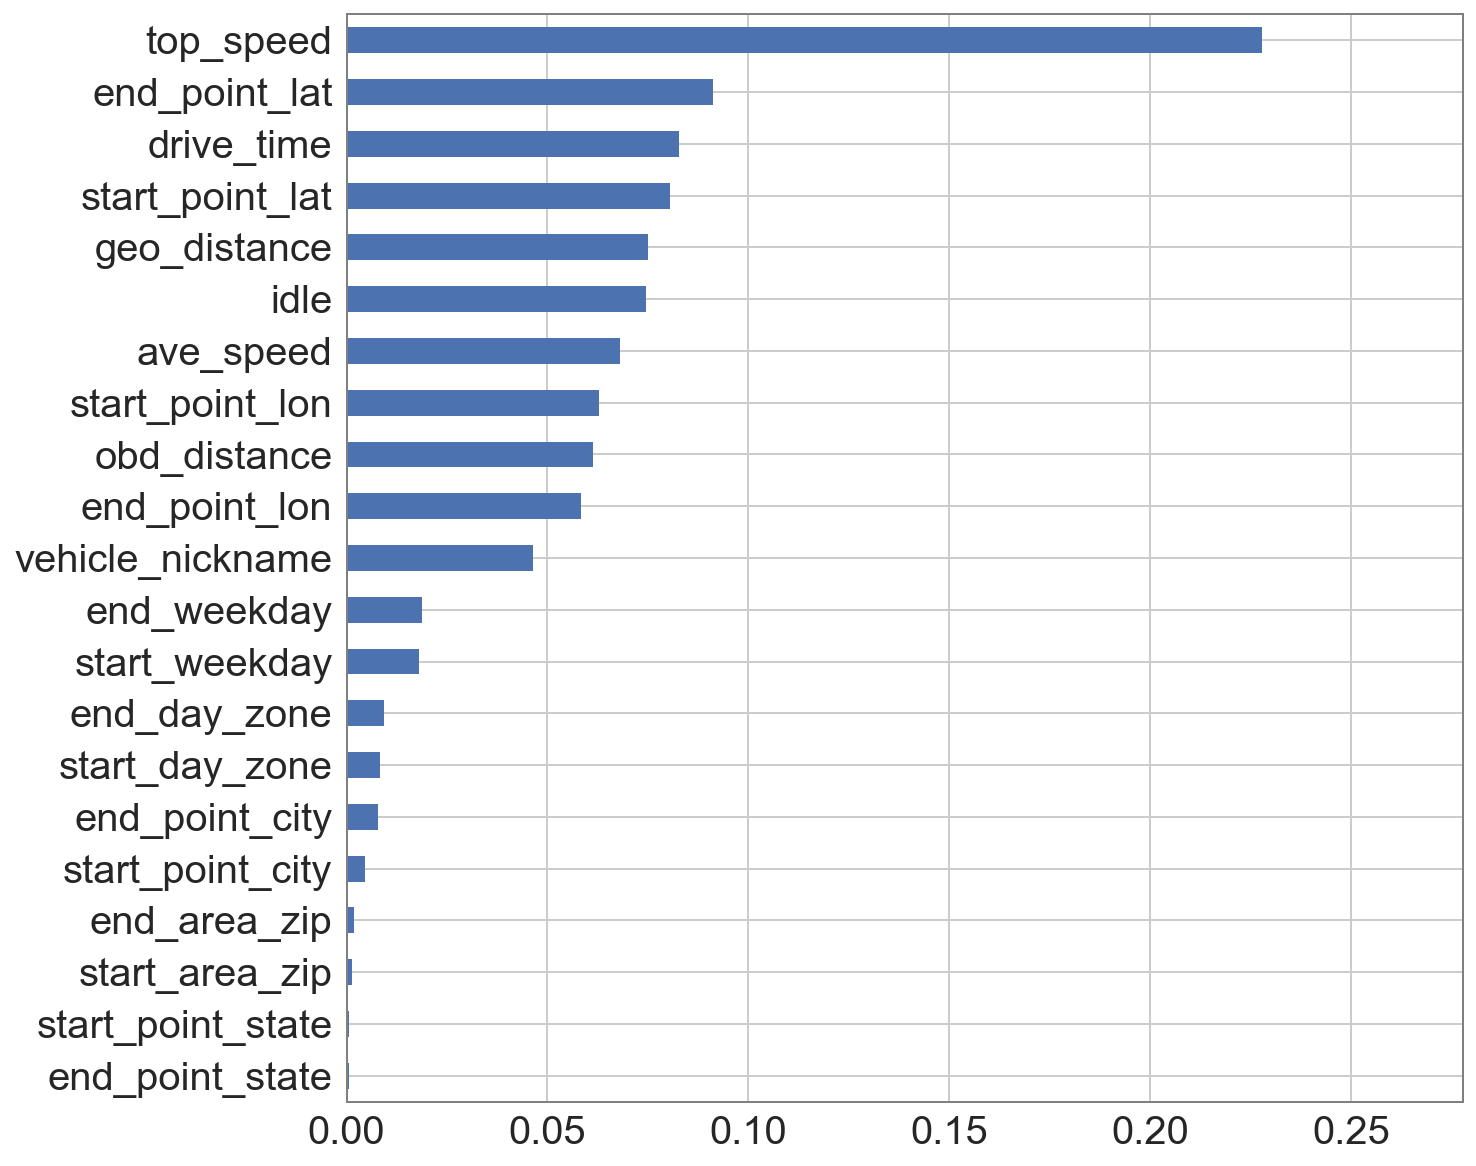

In [144]:
graph_feature_importances(model, X.columns, summarized_columns=categorical_features)

### Hyperparameters Optimization  
   - Parameters to test in order to improve th model:
      - n_estimators: The number of trees in the forest. Choose as high of a number as your computer can handle.  
      - max_features: The number of features to consider when looking for the best split.  
        Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]  
      - min_samples_leaf: The minimum number of samples in newly created leaves.
        Try [1-10]
   - Other params
      - n_jobs: Determines if multiple processors should be used to train and test the model. 
        Always set this to -1 and %%timeit vs. if it is set to 1.   
        It should be much faster (especially when many trees are trained). 
      - random_state: seed for random num generator, using the same value makes the results reproducible
      - oob_score: Random Forest's custom validation method: out-of-bag predictions.

 - Single Hyperparameter optimization
    - in the following params a scanned one by one. This gives a direct idea about the
      impact of the parameter with varying values.  
    - best way is to perform a grid scan so as to exploit also the correlation between
      the hyperparameters. This test has been performed as well (see below) but without
      any noticeble improvement

In [145]:
# turn this off for this section
InteractiveShell.ast_node_interactivity = 'none'

In [146]:
# init values to default values
n_trees_best = 100
features_type_best = 'auto'
samples_leaf_best = 1
max_depth_best = None

 num of trees:  30 -> roc score: 0.76968
 num of trees:  50 -> roc score: 0.77386
 num of trees: 100 -> roc score: 0.78369
 num of trees: 200 -> roc score: 0.78744
 num of trees: 500 -> roc score: 0.79091
 num of trees: 1000 -> roc score: 0.79040
 num of trees: 2000 -> roc score: 0.79105

 num of trees best option: 2000


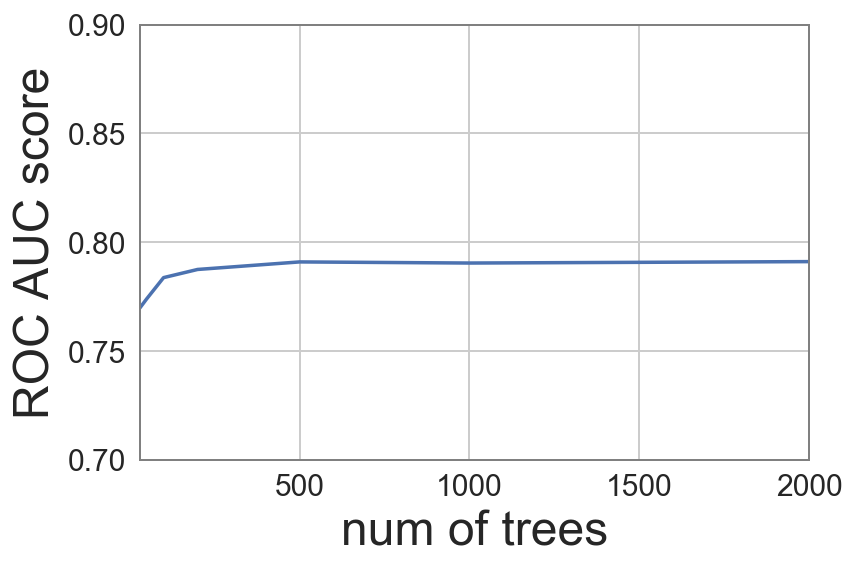

In [147]:
roc_scores = []
n_trees = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_trees:
    model = RandomForestRegressor( n_estimators = trees, oob_score=True, n_jobs=-1, random_state=42 );
    model.fit(X, y);
    score = roc_auc_score(y, model.oob_prediction_)
    roc_scores.append(score)
    print(' num of trees: {0:3d} -> roc score: {1:0.5f}'.format(trees,score))
    
#
n_trees_best = n_trees[ np.argmax(roc_scores) ]
print('\n num of trees best option: {}'.format(n_trees_best))

#
ax = pd.Series(roc_scores, n_trees).plot(fontsize=15, ylim=(0.7,0.9));
ax.set_ylabel('ROC AUC score',**axis_font)
ax.set_xlabel('num of trees',**axis_font)

In [148]:
roc_scores = []
tree_deps = [4, 6, 10, 15]

for dep in tree_deps:
    model = RandomForestRegressor(n_estimators=n_trees_best, max_depth=dep, oob_score=True, n_jobs=-1, random_state=42 );
    model.fit(X, y);
    score = roc_auc_score(y, model.oob_prediction_)
    roc_scores.append(score)
    print(' trees max depth: {0:s} -> roc score: {1:0.5f}'.format(str(dep),score))
  
#
tree_depth_best = tree_deps[ np.argmax(roc_scores) ]
print('\n tree max depth best option: {}'.format(tree_depth_best))

#ax = pd.Series(roc_scores, tree_deps).plot(kind='barh',fontsize=15, ylim=(0.7,0.9));
#ax.set_ylabel('ROC AUC score',**axis_font)
#ax.set_xlabel('num of trees',**axis_font)

 trees max depth: 4 -> roc score: 0.79059
 trees max depth: 6 -> roc score: 0.79945
 trees max depth: 10 -> roc score: 0.79858
 trees max depth: 15 -> roc score: 0.79301

 tree max depth best option: 6


In [149]:

roc_scores = []
max_features_type = ['auto', None, 'sqrt', 'log2', 0.9, 0.2]

for max_features in max_features_type:
    model = RandomForestRegressor(n_estimators = n_trees_best, oob_score=True, n_jobs=-1, max_depth=tree_depth_best,random_state=42,max_features=max_features )
    model.fit(X, y)
    score = roc_auc_score(y, model.oob_prediction_)
    roc_scores.append(score)
    print(' max features option: {0:s} -> roc score: {1:0.5f}'.format(str(max_features),score))
    
#
features_type_best = max_features_type[ np.argmax(roc_scores) ]
print('\n max_feature_type best option: {}'.format(features_type_best))

#ax = pd.Series(roc_scores, max_features_type).plot(kind="barh", fontsize=20, xlim=(.6,.9));
#ax.set_xlabel('ROC AUC score',**axis_font)
#ax.set_ylabel('max feature type',**axis_font)

 max features option: auto -> roc score: 0.79945
 max features option: None -> roc score: 0.79945
 max features option: sqrt -> roc score: 0.80136
 max features option: log2 -> roc score: 0.80136
 max features option: 0.9 -> roc score: 0.80052
 max features option: 0.2 -> roc score: 0.80136

 max_feature_type best option: sqrt


In [150]:

roc_scores = []
min_samples_leaf_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#
for min_samples in min_samples_leaf_num:
    model = RandomForestRegressor(n_estimators=n_trees_best, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_depth=tree_depth_best,
                                  max_features = features_type_best, 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    score = roc_auc_score(y, model.oob_prediction_)
    roc_scores.append(score)
    print(' num of min_samples_leaf: {0:2d} -> roc score: {1:0.5f}'.format(min_samples,score))


    #
samples_leaf_best = min_samples_leaf_num[ np.argmax(roc_scores) ]
print('\n min_samples_leaf_num best option: {}'.format(samples_leaf_best))


#ax = pd.Series(roc_scores, min_samples_leaf_num).plot(fontsize=20, ylim=(0.7,0.9));
#ax.set_ylabel('ROC AUC score',**axis_font)
#ax.set_xlabel('min samples leaf',**axis_font)

 num of min_samples_leaf:  1 -> roc score: 0.80136
 num of min_samples_leaf:  2 -> roc score: 0.80123
 num of min_samples_leaf:  3 -> roc score: 0.80139
 num of min_samples_leaf:  4 -> roc score: 0.80165
 num of min_samples_leaf:  5 -> roc score: 0.80141
 num of min_samples_leaf:  6 -> roc score: 0.80097
 num of min_samples_leaf:  7 -> roc score: 0.80104
 num of min_samples_leaf:  8 -> roc score: 0.80101
 num of min_samples_leaf:  9 -> roc score: 0.80065
 num of min_samples_leaf: 10 -> roc score: 0.80058

 min_samples_leaf_num best option: 4


In [151]:
#example of grid search
#from sklearn.grid_search import GridSearchCV

#model = RandomForestRegressor(random_state=42, n_estimators=2000)
#param_grid = { "max_features"      : [3, 5],
#               "max_depth"         : [4, 10, 20],
#               "min_samples_split" : [2, 4, 10] }
#
#grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=2)
#grid_search.fit(X, y)
#print grid_search.best_params_

In [152]:
# restore full cell output
InteractiveShell.ast_node_interactivity = 'all'

<a id='Conclusions'></a>
***
***
# Conclusions
***
***
[to index](#Index)
 - Major efforts have been put in the data cleaning/preparation and characterization with the goal
   of creating a reliable dataset ready to be used for extensive exploration and modelling.
   The final sample consists of about 4k event out of ~30k of the raw data (many duplicated entries).
   Almost all fields have been examined and checked for integrity and consistency.
 - Data exploration has been carried out with the aim of making sense of the main features and identify
   potential room for ML prediction algorithms. In this phase additional features have been introduced.
 - As first prediction study a Random Forest Regression algo is implemented in order 
   to predict the number of hard maneuvers a driver
   accumulate during a single trip. This step is preceded by of a phase of feature reduction and engineering.
   A prediction accuracy of 80% is achieved at this stage.
 - Additional studies that can be performed with the present sample: 
   - Improve feature understanding (i.e. the one related to points and speeding) and assess
       their power as predictors or targets.
   - Implement pipelines with addional models in order to improve accuracy.
   - Look at longitudinal data: predict individual user behaviour (can be habits, churn etc..)  
 - Further studies should involve a larger dataset. This will open the possibility to run more sophisticated models
   especially for longitudinal data modelling.  
   It will also make possible to run unsupervised ML algorithms which could undercover hidden data correlations to
   be used for prediction models.